In [1]:
import os
import numpy as np
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from pathlib import Path
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import colors
import sys
from tqdm import tqdm
import numpy as np
from numpy.fft import fft2, fftshift
import matplotlib.pyplot as plt


plt.rcParams["image.cmap"] = "jet"

In [2]:
# Setting path
# path = Path("Y:/ptychosaxs")  # /net/micdata/data2/12IDC mounted windows drive
path = Path("/net/micdata/data2/12IDC/ptychosaxs/")
# Join paths
MODEL_SAVE_PATH = path / 'trained_model/' # Automatically adds the correct separator
if (not os.path.isdir(MODEL_SAVE_PATH)):
    os.mkdir(MODEL_SAVE_PATH)
print(MODEL_SAVE_PATH)

/net/micdata/data2/12IDC/ptychosaxs/trained_model


In [3]:
# Load preprocessed data
num=32#17
numDPs=10800#10000

# Load the data
data_path = os.path.abspath(os.path.join(os.getcwd(), f'../../data/processed/preprocessed_dir{num}_no_extra_conv_numDPs{numDPs}.npz'))
data = np.load(data_path)

# Extract the arrays
amp_conv_red = data['amp_conv_red']
amp_ideal_red = data['amp_ideal_red']
amp_probe_red = data['amp_probe_red']

In [4]:
# Set the number of patterns in test, train or validation set
NTEST = amp_conv_red.shape[0]//4
NTRAIN = amp_conv_red.shape[0]-NTEST
NVALID = NTEST//2 # NTRAIN//

print(NTRAIN,NTEST,NVALID)

8100 2700 1350


In [5]:
EPOCHS = 500
NGPUS = 1#torch.cuda.device_count()
BATCH_SIZE = NGPUS*16
LR = NGPUS * 1e-3
print("GPUs:", NGPUS, "Batch size:", BATCH_SIZE, "Learning rate:", LR)

no_probe=True
H,W=amp_ideal_red[0].shape[0],amp_ideal_red[0].shape[1]
print(H,W)

GPUs: 1 Batch size: 16 Learning rate: 0.001
256 256


In [6]:
#separate data and convert to tensors and shuffle
no_probe=True

tst_start = amp_conv_red.shape[0]-NTEST

X_train = amp_conv_red[:NTRAIN].reshape(-1,H,W)[:,np.newaxis,:,:]
X_test = amp_conv_red[tst_start:].reshape(-1,H,W)[:,np.newaxis,:,:]

Xp_train = amp_probe_red[:NTRAIN].reshape(-1,H,W)[:,np.newaxis,:,:]
Xp_test = amp_probe_red[tst_start:].reshape(-1,H,W)[:,np.newaxis,:,:]

Y_I_train = amp_ideal_red[:NTRAIN].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_I_test = amp_ideal_red[tst_start:].reshape(-1,H,W)[:,np.newaxis,:,:]

ntrain=X_train.shape[0]
ntest=X_test.shape[0]

X_train, Xp_train, Y_I_train = shuffle(X_train, Xp_train, Y_I_train, random_state=0)

#Training data
X_train_tensor = torch.Tensor(X_train)
Xp_train_tensor = torch.Tensor(Xp_train) 
Y_I_train_tensor = torch.Tensor(Y_I_train) 

#Test data
X_test_tensor = torch.Tensor(X_test)
Xp_test_tensor = torch.Tensor(Xp_test) 
Y_I_test_tensor = torch.Tensor(Y_I_test) 

print(X_train_tensor.shape,Xp_train_tensor.shape, Y_I_train_tensor.shape)


if no_probe:
    train_data = TensorDataset(X_train_tensor,Y_I_train_tensor)
    test_data = TensorDataset(X_test_tensor,Xp_test_tensor)
else:
    train_data = TensorDataset(X_train_tensor,Xp_train_tensor,Y_I_train_tensor)
    test_data = TensorDataset(X_test_tensor,Xp_test_tensor)


N_TRAIN = X_train_tensor.shape[0]

train_data2, valid_data = torch.utils.data.random_split(train_data,[N_TRAIN-NVALID,NVALID])
print(len(train_data2),len(train_data2[0]),len(valid_data),len(test_data))


#download and load training data
trainloader = DataLoader(train_data2, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

validloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

#same for test
#download and load training data
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

torch.Size([8100, 1, 256, 256]) torch.Size([8100, 1, 256, 256]) torch.Size([8100, 1, 256, 256])
6750 2 1350 2700


In [23]:
import sys
import os
import importlib

# Add the models directory to the path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../src/models/')))

# # First, try to import the module
# try:
#     import encoder1_no_Unet
#     # Force reload the module
#     importlib.reload(encoder1_no_Unet)
#     # Now import the class from the freshly reloaded module
#     from encoder1_no_Unet import recon_model
#     print("Successfully imported recon_model")
#     unet_status = "no_Unet"
#     loss_function = "L2"
# except Exception as e:
#     print(f"Import error: {e}")
    
#First, try to import the module
try:
    import encoder1
    importlib.reload(encoder1)
    # Now import the class from the freshly reloaded module
    from encoder1 import recon_model
    print("Successfully imported recon_model")
    unet_status = "Unet"
    loss_function = "pearson_loss"
    #loss_function = "L2"
except Exception as e:
    print(f"Import error: {e}")


model = recon_model()
load_prev_model=False

Successfully imported recon_model


In [24]:
if no_probe:
    for ampsI,ampsO in trainloader:
        print("batch size:", ampsI.shape)
        amp = model(ampsI)#,ampsP)
        print(amp.shape)
        print(amp.dtype)
        break
else:
    for ampsI,ampsP,ampsO in trainloader:
        print("batch size:", ampsI.shape)
        amp = model(ampsI,ampsP)
        print(amp.shape)
        print(amp.dtype)
        break    

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# if torch.cuda.device_count() > 1:
#     print("Let's use", torch.cuda.device_count(), "GPUs!")
#     # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
#     #model = nn.parallel.DistributedDataParallel(model) #Default all devices
#     model = nn.DataParallel(model)
    
if NGPUS > 1:
    print("Let's use", NGPUS, "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    #model = nn.parallel.DistributedDataParallel(model) #Default all devices
    model = nn.DataParallel(model)

model = model.to(device)
print(model)

batch size: torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])
torch.float32
recon_model(
  (encoder1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Batch

In [25]:
def pearson_loss(output, target):
    """
    Compute 1 - Pearson correlation coefficient as a loss function.
    Args:
        output: Predicted values (B, C, H, W)
        target: Target values (B, C, H, W)
    Returns:
        loss: 1 - correlation (to minimize)
    """
    # Flatten the spatial dimensions
    output_flat = output.view(output.size(0), -1)
    target_flat = target.view(target.size(0), -1)
    
    # Mean of each image
    output_mean = output_flat.mean(dim=1, keepdim=True)
    target_mean = target_flat.mean(dim=1, keepdim=True)
    
    # Centered variables
    output_centered = output_flat - output_mean
    target_centered = target_flat - target_mean
    
    # Correlation
    numerator = (output_centered * target_centered).sum(dim=1)
    denominator = torch.sqrt((output_centered**2).sum(dim=1) * (target_centered**2).sum(dim=1))
    
    # Avoid division by zero
    correlation = numerator / (denominator + 1e-8)
    
    # Average over batch and convert to loss (1 - correlation)
    loss = 1 - correlation.mean()
    
    #Negaive pearson loss
    #loss = 1 + correlation.mean()
    
    return loss

In [26]:
#Optimizer details
iterations_per_epoch = np.floor((NTRAIN-NVALID)/BATCH_SIZE)+1 #Final batch will be less than batch size
step_size = 6*iterations_per_epoch #Paper recommends 2-10 (6) number of iterations, step_size is half cycle
print(iterations_per_epoch)
print("LR step size is:", step_size, "which is every %d epochs" %(step_size/iterations_per_epoch))



#criterion = nn.L1Loss()
#criterion = nn.MSELoss()
    

optimizer = torch.optim.Adam(model.parameters(), lr = LR, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=LR/10, max_lr=LR, step_size_up=step_size,
                                              cycle_momentum=False, mode='triangular2')
                                              
                                            
#Function to update saved model if validation loss is minimum

def update_saved_model(model, path, current_epoch, best_val_loss):
    if not os.path.isdir(path):
        os.mkdir(path)
    
    # Save the best overall model
    if (NGPUS>1):    
        torch.save(model.module.state_dict(), path / f'best_model_ZCB_9_{num}_no_extra_conv_{unet_status}_{loss_function}.pth')
    else:
        torch.save(model.state_dict(), path / f'best_model_ZCB_9_{num}_no_extra_conv_{unet_status}_{loss_function}.pth')
    
    # Define epoch intervals (50, 100, 150, etc.)
    epoch_intervals = [2, 10, 25, 50, 100, 150, 200, 250, 300, 400, 500]
    
    # For each interval, save the best model within that interval
    for interval in epoch_intervals:
        if current_epoch <= interval:
            # Create a filename that includes the epoch interval
            interval_filename = f'best_model_ZCB_9_{num}_no_extra_conv_{unet_status}_epoch_{interval}_{loss_function}.pth'
            interval_path = path / interval_filename
            
            # If this is the first time we're saving for this interval, save the model
            if not interval_path.exists():
                if (NGPUS>1):
                    torch.save(model.module.state_dict(), interval_path)
                else:
                    torch.save(model.state_dict(), interval_path)
                print(f"Saving best model for epoch interval {interval} at epoch {current_epoch}")
            # If we already have a model for this interval, only update if the current loss is better
            else:
                # Load the previous best loss for this interval
                prev_loss_path = path / f'best_loss_epoch_{num}_no_extra_conv_{unet_status}_{interval}_{loss_function}.txt'
                if prev_loss_path.exists():
                    with open(prev_loss_path, 'r') as f:
                        prev_best_loss = float(f.read().strip())
                    
                    # Update if current loss is better
                    if best_val_loss < prev_best_loss:
                        if (NGPUS>1):
                            torch.save(model.module.state_dict(), interval_path)
                        else:
                            torch.save(model.state_dict(), interval_path)
                        with open(prev_loss_path, 'w') as f:
                            f.write(str(best_val_loss))
                        print(f"Updating best model for epoch interval {interval} at epoch {current_epoch}")
                else:
                    # First time saving for this interval
                    if (NGPUS>1):
                        torch.save(model.module.state_dict(), interval_path)
                    else:
                        torch.save(model.state_dict(), interval_path)
                    with open(prev_loss_path, 'w') as f:
                        f.write(str(best_val_loss))
                    print(f"Saving best model for epoch interval {interval} at epoch {current_epoch}")



def train(trainloader,metrics):
    tot_loss = 0.0
    loss_amp = 0.0
    
    for i, (ft_images,amps) in tqdm(enumerate(trainloader)):
        ft_images = ft_images.to(device) #Move everything to device
        amps = amps.to(device)
        pred_amps = model(ft_images) #Forward pass
        
        #Compute losses
        #loss_a = criterion(pred_amps,amps) #Monitor amplitude loss
        loss_a = pearson_loss(pred_amps,amps)
        loss = loss_a #Use equiweighted amps and phase

        #Zero current grads and do backprop
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

        tot_loss += loss.detach().item()
        loss_amp += loss_a.detach().item()

        #Update the LR according to the schedule -- CyclicLR updates each batch
        scheduler.step() 
        metrics['lrs'].append(scheduler.get_last_lr())
        
        
    #Divide cumulative loss by number of batches-- sli inaccurate because last batch is different size
    metrics['losses'].append([tot_loss/i,loss_amp/i]) 
    
def validate(validloader,metrics):
    tot_val_loss = 0.0
    val_loss_amp = 0.0
    for j, (ft_images,amps) in enumerate(validloader):
        ft_images = ft_images.to(device)
        amps = amps.to(device)
        pred_amps = model(ft_images) #Forward pass

        #val_loss_a = criterion(pred_amps,amps)
        val_loss_a = pearson_loss(pred_amps,amps)
        val_loss = val_loss_a
    
        tot_val_loss += val_loss.detach().item()
        val_loss_amp += val_loss_a.detach().item()
    metrics['val_losses'].append([tot_val_loss/j,val_loss_amp/j])
  
    #Update saved model if val loss is lower
    if(tot_val_loss/j<metrics['best_val_loss']):
        print("Saving improved model after Val Loss improved from %.5f to %.5f" %(metrics['best_val_loss'],tot_val_loss/j))
        metrics['best_val_loss'] = tot_val_loss/j
        update_saved_model(model, MODEL_SAVE_PATH, metrics['current_epoch'], tot_val_loss/j)



422.0
LR step size is: 2532.0 which is every 6 epochs


In [27]:
# Initialize metrics dictionary with current_epoch
metrics = {
    'losses': [],
    'val_losses': [],
    'lrs': [],
    'best_val_loss': float('inf'),
    'current_epoch': 0
}

for epoch in range (EPOCHS):
    metrics['current_epoch'] = epoch  # Update current epoch in metrics
    
    #Set model to train mode
    model.train() 
    #Training loop
    train(trainloader,metrics)
    
    #Switch model to eval mode
    model.eval()
    
    #Validation loop
    validate(validloader,metrics)
    print('Epoch: %d | Total  | Train Loss: %.5f | Val Loss: %.5f' %(epoch, metrics['losses'][-1][0], metrics['val_losses'][-1][0]))
    print('Epoch: %d | Amp | Train Loss: %.5f | Val Loss: %.5f' %(epoch, metrics['losses'][-1][1], metrics['val_losses'][-1][1]))
    print('Epoch: %d | Ending LR: %.6f ' %(epoch, metrics['lrs'][-1][0]))

422it [00:42, 10.03it/s]


Saving improved model after Val Loss improved from inf to 0.53270
Saving best model for epoch interval 2 at epoch 0
Saving best model for epoch interval 10 at epoch 0
Saving best model for epoch interval 25 at epoch 0
Saving best model for epoch interval 50 at epoch 0
Saving best model for epoch interval 100 at epoch 0
Saving best model for epoch interval 150 at epoch 0
Saving best model for epoch interval 200 at epoch 0
Saving best model for epoch interval 250 at epoch 0
Saving best model for epoch interval 300 at epoch 0
Saving best model for epoch interval 400 at epoch 0
Saving best model for epoch interval 500 at epoch 0
Epoch: 0 | Total  | Train Loss: 0.37229 | Val Loss: 0.53270
Epoch: 0 | Amp | Train Loss: 0.37229 | Val Loss: 0.53270
Epoch: 0 | Ending LR: 0.000250 


422it [00:41, 10.08it/s]


Saving improved model after Val Loss improved from 0.53270 to 0.38439
Saving best model for epoch interval 2 at epoch 1
Saving best model for epoch interval 10 at epoch 1
Saving best model for epoch interval 25 at epoch 1
Saving best model for epoch interval 50 at epoch 1
Saving best model for epoch interval 100 at epoch 1
Saving best model for epoch interval 150 at epoch 1
Saving best model for epoch interval 200 at epoch 1
Saving best model for epoch interval 250 at epoch 1
Saving best model for epoch interval 300 at epoch 1
Saving best model for epoch interval 400 at epoch 1
Saving best model for epoch interval 500 at epoch 1
Epoch: 1 | Total  | Train Loss: 0.33663 | Val Loss: 0.38439
Epoch: 1 | Amp | Train Loss: 0.33663 | Val Loss: 0.38439
Epoch: 1 | Ending LR: 0.000400 


422it [00:42, 10.03it/s]


Saving improved model after Val Loss improved from 0.38439 to 0.33475
Updating best model for epoch interval 2 at epoch 2
Updating best model for epoch interval 10 at epoch 2
Updating best model for epoch interval 25 at epoch 2
Updating best model for epoch interval 50 at epoch 2
Updating best model for epoch interval 100 at epoch 2
Updating best model for epoch interval 150 at epoch 2
Updating best model for epoch interval 200 at epoch 2
Updating best model for epoch interval 250 at epoch 2
Updating best model for epoch interval 300 at epoch 2
Updating best model for epoch interval 400 at epoch 2
Updating best model for epoch interval 500 at epoch 2
Epoch: 2 | Total  | Train Loss: 0.32358 | Val Loss: 0.33475
Epoch: 2 | Amp | Train Loss: 0.32358 | Val Loss: 0.33475
Epoch: 2 | Ending LR: 0.000550 


422it [00:42, 10.03it/s]


Epoch: 3 | Total  | Train Loss: 0.31652 | Val Loss: 0.36900
Epoch: 3 | Amp | Train Loss: 0.31652 | Val Loss: 0.36900
Epoch: 3 | Ending LR: 0.000700 


422it [00:42, 10.04it/s]


Saving improved model after Val Loss improved from 0.33475 to 0.31270
Updating best model for epoch interval 10 at epoch 4
Updating best model for epoch interval 25 at epoch 4
Updating best model for epoch interval 50 at epoch 4
Updating best model for epoch interval 100 at epoch 4
Updating best model for epoch interval 150 at epoch 4
Updating best model for epoch interval 200 at epoch 4
Updating best model for epoch interval 250 at epoch 4
Updating best model for epoch interval 300 at epoch 4
Updating best model for epoch interval 400 at epoch 4
Updating best model for epoch interval 500 at epoch 4
Epoch: 4 | Total  | Train Loss: 0.30873 | Val Loss: 0.31270
Epoch: 4 | Amp | Train Loss: 0.30873 | Val Loss: 0.31270
Epoch: 4 | Ending LR: 0.000850 


422it [00:42,  9.94it/s]


Saving improved model after Val Loss improved from 0.31270 to 0.31159
Updating best model for epoch interval 10 at epoch 5
Updating best model for epoch interval 25 at epoch 5
Updating best model for epoch interval 50 at epoch 5
Updating best model for epoch interval 100 at epoch 5
Updating best model for epoch interval 150 at epoch 5
Updating best model for epoch interval 200 at epoch 5
Updating best model for epoch interval 250 at epoch 5
Updating best model for epoch interval 300 at epoch 5
Updating best model for epoch interval 400 at epoch 5
Updating best model for epoch interval 500 at epoch 5
Epoch: 5 | Total  | Train Loss: 0.29985 | Val Loss: 0.31159
Epoch: 5 | Amp | Train Loss: 0.29985 | Val Loss: 0.31159
Epoch: 5 | Ending LR: 0.001000 


422it [00:41, 10.07it/s]


Saving improved model after Val Loss improved from 0.31159 to 0.29056
Updating best model for epoch interval 10 at epoch 6
Updating best model for epoch interval 25 at epoch 6
Updating best model for epoch interval 50 at epoch 6
Updating best model for epoch interval 100 at epoch 6
Updating best model for epoch interval 150 at epoch 6
Updating best model for epoch interval 200 at epoch 6
Updating best model for epoch interval 250 at epoch 6
Updating best model for epoch interval 300 at epoch 6
Updating best model for epoch interval 400 at epoch 6
Updating best model for epoch interval 500 at epoch 6
Epoch: 6 | Total  | Train Loss: 0.29032 | Val Loss: 0.29056
Epoch: 6 | Amp | Train Loss: 0.29032 | Val Loss: 0.29056
Epoch: 6 | Ending LR: 0.000850 


422it [00:42, 10.04it/s]


Saving improved model after Val Loss improved from 0.29056 to 0.28468
Updating best model for epoch interval 10 at epoch 7
Updating best model for epoch interval 25 at epoch 7
Updating best model for epoch interval 50 at epoch 7
Updating best model for epoch interval 100 at epoch 7
Updating best model for epoch interval 150 at epoch 7
Updating best model for epoch interval 200 at epoch 7
Updating best model for epoch interval 250 at epoch 7
Updating best model for epoch interval 300 at epoch 7
Updating best model for epoch interval 400 at epoch 7
Updating best model for epoch interval 500 at epoch 7
Epoch: 7 | Total  | Train Loss: 0.28091 | Val Loss: 0.28468
Epoch: 7 | Amp | Train Loss: 0.28091 | Val Loss: 0.28468
Epoch: 7 | Ending LR: 0.000700 


422it [00:42, 10.03it/s]


Saving improved model after Val Loss improved from 0.28468 to 0.27113
Updating best model for epoch interval 10 at epoch 8
Updating best model for epoch interval 25 at epoch 8
Updating best model for epoch interval 50 at epoch 8
Updating best model for epoch interval 100 at epoch 8
Updating best model for epoch interval 150 at epoch 8
Updating best model for epoch interval 200 at epoch 8
Updating best model for epoch interval 250 at epoch 8
Updating best model for epoch interval 300 at epoch 8
Updating best model for epoch interval 400 at epoch 8
Updating best model for epoch interval 500 at epoch 8
Epoch: 8 | Total  | Train Loss: 0.27480 | Val Loss: 0.27113
Epoch: 8 | Amp | Train Loss: 0.27480 | Val Loss: 0.27113
Epoch: 8 | Ending LR: 0.000550 


422it [00:41, 10.06it/s]


Epoch: 9 | Total  | Train Loss: 0.26866 | Val Loss: 0.27626
Epoch: 9 | Amp | Train Loss: 0.26866 | Val Loss: 0.27626
Epoch: 9 | Ending LR: 0.000400 


422it [00:42, 10.04it/s]


Saving improved model after Val Loss improved from 0.27113 to 0.26102
Updating best model for epoch interval 10 at epoch 10
Updating best model for epoch interval 25 at epoch 10
Updating best model for epoch interval 50 at epoch 10
Updating best model for epoch interval 100 at epoch 10
Updating best model for epoch interval 150 at epoch 10
Updating best model for epoch interval 200 at epoch 10
Updating best model for epoch interval 250 at epoch 10
Updating best model for epoch interval 300 at epoch 10
Updating best model for epoch interval 400 at epoch 10
Updating best model for epoch interval 500 at epoch 10
Epoch: 10 | Total  | Train Loss: 0.26286 | Val Loss: 0.26102
Epoch: 10 | Amp | Train Loss: 0.26286 | Val Loss: 0.26102
Epoch: 10 | Ending LR: 0.000250 


422it [00:42, 10.00it/s]


Saving improved model after Val Loss improved from 0.26102 to 0.25509
Updating best model for epoch interval 25 at epoch 11
Updating best model for epoch interval 50 at epoch 11
Updating best model for epoch interval 100 at epoch 11
Updating best model for epoch interval 150 at epoch 11
Updating best model for epoch interval 200 at epoch 11
Updating best model for epoch interval 250 at epoch 11
Updating best model for epoch interval 300 at epoch 11
Updating best model for epoch interval 400 at epoch 11
Updating best model for epoch interval 500 at epoch 11
Epoch: 11 | Total  | Train Loss: 0.25762 | Val Loss: 0.25509
Epoch: 11 | Amp | Train Loss: 0.25762 | Val Loss: 0.25509
Epoch: 11 | Ending LR: 0.000100 


422it [00:42, 10.04it/s]


Epoch: 12 | Total  | Train Loss: 0.25442 | Val Loss: 0.25576
Epoch: 12 | Amp | Train Loss: 0.25442 | Val Loss: 0.25576
Epoch: 12 | Ending LR: 0.000175 


422it [00:42, 10.04it/s]


Epoch: 13 | Total  | Train Loss: 0.25472 | Val Loss: 0.25833
Epoch: 13 | Amp | Train Loss: 0.25472 | Val Loss: 0.25833
Epoch: 13 | Ending LR: 0.000250 


422it [00:42, 10.04it/s]


Epoch: 14 | Total  | Train Loss: 0.25508 | Val Loss: 0.25626
Epoch: 14 | Amp | Train Loss: 0.25508 | Val Loss: 0.25626
Epoch: 14 | Ending LR: 0.000325 


422it [00:42, 10.05it/s]


Epoch: 15 | Total  | Train Loss: 0.25556 | Val Loss: 0.25711
Epoch: 15 | Amp | Train Loss: 0.25556 | Val Loss: 0.25711
Epoch: 15 | Ending LR: 0.000400 


422it [00:42, 10.04it/s]


Epoch: 16 | Total  | Train Loss: 0.25595 | Val Loss: 0.25948
Epoch: 16 | Amp | Train Loss: 0.25595 | Val Loss: 0.25948
Epoch: 16 | Ending LR: 0.000475 


422it [00:42, 10.02it/s]


Epoch: 17 | Total  | Train Loss: 0.25608 | Val Loss: 0.26411
Epoch: 17 | Amp | Train Loss: 0.25608 | Val Loss: 0.26411
Epoch: 17 | Ending LR: 0.000550 


422it [00:41, 10.08it/s]


Epoch: 18 | Total  | Train Loss: 0.25459 | Val Loss: 0.26104
Epoch: 18 | Amp | Train Loss: 0.25459 | Val Loss: 0.26104
Epoch: 18 | Ending LR: 0.000475 


422it [00:41, 10.07it/s]


Epoch: 19 | Total  | Train Loss: 0.25118 | Val Loss: 0.25698
Epoch: 19 | Amp | Train Loss: 0.25118 | Val Loss: 0.25698
Epoch: 19 | Ending LR: 0.000400 


422it [00:41, 10.06it/s]


Saving improved model after Val Loss improved from 0.25509 to 0.25094
Updating best model for epoch interval 25 at epoch 20
Updating best model for epoch interval 50 at epoch 20
Updating best model for epoch interval 100 at epoch 20
Updating best model for epoch interval 150 at epoch 20
Updating best model for epoch interval 200 at epoch 20
Updating best model for epoch interval 250 at epoch 20
Updating best model for epoch interval 300 at epoch 20
Updating best model for epoch interval 400 at epoch 20
Updating best model for epoch interval 500 at epoch 20
Epoch: 20 | Total  | Train Loss: 0.24803 | Val Loss: 0.25094
Epoch: 20 | Amp | Train Loss: 0.24803 | Val Loss: 0.25094
Epoch: 20 | Ending LR: 0.000325 


422it [00:42, 10.02it/s]


Epoch: 21 | Total  | Train Loss: 0.24487 | Val Loss: 0.25284
Epoch: 21 | Amp | Train Loss: 0.24487 | Val Loss: 0.25284
Epoch: 21 | Ending LR: 0.000250 


422it [00:41, 10.08it/s]


Saving improved model after Val Loss improved from 0.25094 to 0.24596
Updating best model for epoch interval 25 at epoch 22
Updating best model for epoch interval 50 at epoch 22
Updating best model for epoch interval 100 at epoch 22
Updating best model for epoch interval 150 at epoch 22
Updating best model for epoch interval 200 at epoch 22
Updating best model for epoch interval 250 at epoch 22
Updating best model for epoch interval 300 at epoch 22
Updating best model for epoch interval 400 at epoch 22
Updating best model for epoch interval 500 at epoch 22
Epoch: 22 | Total  | Train Loss: 0.24161 | Val Loss: 0.24596
Epoch: 22 | Amp | Train Loss: 0.24161 | Val Loss: 0.24596
Epoch: 22 | Ending LR: 0.000175 


422it [00:42, 10.04it/s]


Saving improved model after Val Loss improved from 0.24596 to 0.24279
Updating best model for epoch interval 25 at epoch 23
Updating best model for epoch interval 50 at epoch 23
Updating best model for epoch interval 100 at epoch 23
Updating best model for epoch interval 150 at epoch 23
Updating best model for epoch interval 200 at epoch 23
Updating best model for epoch interval 250 at epoch 23
Updating best model for epoch interval 300 at epoch 23
Updating best model for epoch interval 400 at epoch 23
Updating best model for epoch interval 500 at epoch 23
Epoch: 23 | Total  | Train Loss: 0.23799 | Val Loss: 0.24279
Epoch: 23 | Amp | Train Loss: 0.23799 | Val Loss: 0.24279
Epoch: 23 | Ending LR: 0.000100 


422it [00:42,  9.97it/s]


Saving improved model after Val Loss improved from 0.24279 to 0.24142
Updating best model for epoch interval 25 at epoch 24
Updating best model for epoch interval 50 at epoch 24
Updating best model for epoch interval 100 at epoch 24
Updating best model for epoch interval 150 at epoch 24
Updating best model for epoch interval 200 at epoch 24
Updating best model for epoch interval 250 at epoch 24
Updating best model for epoch interval 300 at epoch 24
Updating best model for epoch interval 400 at epoch 24
Updating best model for epoch interval 500 at epoch 24
Epoch: 24 | Total  | Train Loss: 0.23582 | Val Loss: 0.24142
Epoch: 24 | Amp | Train Loss: 0.23582 | Val Loss: 0.24142
Epoch: 24 | Ending LR: 0.000138 


422it [00:42, 10.03it/s]


Epoch: 25 | Total  | Train Loss: 0.23615 | Val Loss: 0.24376
Epoch: 25 | Amp | Train Loss: 0.23615 | Val Loss: 0.24376
Epoch: 25 | Ending LR: 0.000175 


422it [00:42, 10.03it/s]


Epoch: 26 | Total  | Train Loss: 0.23635 | Val Loss: 0.24670
Epoch: 26 | Amp | Train Loss: 0.23635 | Val Loss: 0.24670
Epoch: 26 | Ending LR: 0.000213 


422it [00:41, 10.08it/s]


Epoch: 27 | Total  | Train Loss: 0.23688 | Val Loss: 0.24609
Epoch: 27 | Amp | Train Loss: 0.23688 | Val Loss: 0.24609
Epoch: 27 | Ending LR: 0.000250 


422it [00:41, 10.14it/s]


Epoch: 28 | Total  | Train Loss: 0.23721 | Val Loss: 0.24841
Epoch: 28 | Amp | Train Loss: 0.23721 | Val Loss: 0.24841
Epoch: 28 | Ending LR: 0.000287 


422it [00:41, 10.12it/s]


Epoch: 29 | Total  | Train Loss: 0.23796 | Val Loss: 0.25492
Epoch: 29 | Amp | Train Loss: 0.23796 | Val Loss: 0.25492
Epoch: 29 | Ending LR: 0.000325 


422it [00:41, 10.13it/s]


Epoch: 30 | Total  | Train Loss: 0.23729 | Val Loss: 0.24550
Epoch: 30 | Amp | Train Loss: 0.23729 | Val Loss: 0.24550
Epoch: 30 | Ending LR: 0.000287 


422it [00:41, 10.11it/s]


Saving improved model after Val Loss improved from 0.24142 to 0.24027
Updating best model for epoch interval 50 at epoch 31
Updating best model for epoch interval 100 at epoch 31
Updating best model for epoch interval 150 at epoch 31
Updating best model for epoch interval 200 at epoch 31
Updating best model for epoch interval 250 at epoch 31
Updating best model for epoch interval 300 at epoch 31
Updating best model for epoch interval 400 at epoch 31
Updating best model for epoch interval 500 at epoch 31
Epoch: 31 | Total  | Train Loss: 0.23527 | Val Loss: 0.24027
Epoch: 31 | Amp | Train Loss: 0.23527 | Val Loss: 0.24027
Epoch: 31 | Ending LR: 0.000250 


422it [00:42, 10.03it/s]


Epoch: 32 | Total  | Train Loss: 0.23314 | Val Loss: 0.24058
Epoch: 32 | Amp | Train Loss: 0.23314 | Val Loss: 0.24058
Epoch: 32 | Ending LR: 0.000213 


422it [00:41, 10.15it/s]


Epoch: 33 | Total  | Train Loss: 0.23096 | Val Loss: 0.24518
Epoch: 33 | Amp | Train Loss: 0.23096 | Val Loss: 0.24518
Epoch: 33 | Ending LR: 0.000175 


422it [00:41, 10.15it/s]


Saving improved model after Val Loss improved from 0.24027 to 0.23664
Updating best model for epoch interval 50 at epoch 34
Updating best model for epoch interval 100 at epoch 34
Updating best model for epoch interval 150 at epoch 34
Updating best model for epoch interval 200 at epoch 34
Updating best model for epoch interval 250 at epoch 34
Updating best model for epoch interval 300 at epoch 34
Updating best model for epoch interval 400 at epoch 34
Updating best model for epoch interval 500 at epoch 34
Epoch: 34 | Total  | Train Loss: 0.22887 | Val Loss: 0.23664
Epoch: 34 | Amp | Train Loss: 0.22887 | Val Loss: 0.23664
Epoch: 34 | Ending LR: 0.000138 


422it [00:41, 10.14it/s]


Saving improved model after Val Loss improved from 0.23664 to 0.23631
Updating best model for epoch interval 50 at epoch 35
Updating best model for epoch interval 100 at epoch 35
Updating best model for epoch interval 150 at epoch 35
Updating best model for epoch interval 200 at epoch 35
Updating best model for epoch interval 250 at epoch 35
Updating best model for epoch interval 300 at epoch 35
Updating best model for epoch interval 400 at epoch 35
Updating best model for epoch interval 500 at epoch 35
Epoch: 35 | Total  | Train Loss: 0.22636 | Val Loss: 0.23631
Epoch: 35 | Amp | Train Loss: 0.22636 | Val Loss: 0.23631
Epoch: 35 | Ending LR: 0.000100 


422it [00:41, 10.14it/s]


Epoch: 36 | Total  | Train Loss: 0.22476 | Val Loss: 0.23772
Epoch: 36 | Amp | Train Loss: 0.22476 | Val Loss: 0.23772
Epoch: 36 | Ending LR: 0.000119 


422it [00:41, 10.14it/s]


Epoch: 37 | Total  | Train Loss: 0.22487 | Val Loss: 0.23687
Epoch: 37 | Amp | Train Loss: 0.22487 | Val Loss: 0.23687
Epoch: 37 | Ending LR: 0.000137 


422it [00:41, 10.10it/s]


Saving improved model after Val Loss improved from 0.23631 to 0.23617
Updating best model for epoch interval 50 at epoch 38
Updating best model for epoch interval 100 at epoch 38
Updating best model for epoch interval 150 at epoch 38
Updating best model for epoch interval 200 at epoch 38
Updating best model for epoch interval 250 at epoch 38
Updating best model for epoch interval 300 at epoch 38
Updating best model for epoch interval 400 at epoch 38
Updating best model for epoch interval 500 at epoch 38
Epoch: 38 | Total  | Train Loss: 0.22485 | Val Loss: 0.23617
Epoch: 38 | Amp | Train Loss: 0.22485 | Val Loss: 0.23617
Epoch: 38 | Ending LR: 0.000156 


422it [00:41, 10.10it/s]


Epoch: 39 | Total  | Train Loss: 0.22506 | Val Loss: 0.23770
Epoch: 39 | Amp | Train Loss: 0.22506 | Val Loss: 0.23770
Epoch: 39 | Ending LR: 0.000175 


422it [00:41, 10.14it/s]


Epoch: 40 | Total  | Train Loss: 0.22520 | Val Loss: 0.25446
Epoch: 40 | Amp | Train Loss: 0.22520 | Val Loss: 0.25446
Epoch: 40 | Ending LR: 0.000194 


422it [00:41, 10.10it/s]


Epoch: 41 | Total  | Train Loss: 0.22548 | Val Loss: 0.23758
Epoch: 41 | Amp | Train Loss: 0.22548 | Val Loss: 0.23758
Epoch: 41 | Ending LR: 0.000213 


422it [00:41, 10.14it/s]


Epoch: 42 | Total  | Train Loss: 0.22554 | Val Loss: 0.23886
Epoch: 42 | Amp | Train Loss: 0.22554 | Val Loss: 0.23886
Epoch: 42 | Ending LR: 0.000194 


422it [00:41, 10.10it/s]


Epoch: 43 | Total  | Train Loss: 0.22394 | Val Loss: 0.23619
Epoch: 43 | Amp | Train Loss: 0.22394 | Val Loss: 0.23619
Epoch: 43 | Ending LR: 0.000175 


422it [00:41, 10.12it/s]


Epoch: 44 | Total  | Train Loss: 0.22241 | Val Loss: 0.23684
Epoch: 44 | Amp | Train Loss: 0.22241 | Val Loss: 0.23684
Epoch: 44 | Ending LR: 0.000156 


422it [00:41, 10.14it/s]


Epoch: 45 | Total  | Train Loss: 0.22100 | Val Loss: 0.23619
Epoch: 45 | Amp | Train Loss: 0.22100 | Val Loss: 0.23619
Epoch: 45 | Ending LR: 0.000137 


422it [00:41, 10.11it/s]


Saving improved model after Val Loss improved from 0.23617 to 0.23411
Updating best model for epoch interval 50 at epoch 46
Updating best model for epoch interval 100 at epoch 46
Updating best model for epoch interval 150 at epoch 46
Updating best model for epoch interval 200 at epoch 46
Updating best model for epoch interval 250 at epoch 46
Updating best model for epoch interval 300 at epoch 46
Updating best model for epoch interval 400 at epoch 46
Updating best model for epoch interval 500 at epoch 46
Epoch: 46 | Total  | Train Loss: 0.21949 | Val Loss: 0.23411
Epoch: 46 | Amp | Train Loss: 0.21949 | Val Loss: 0.23411
Epoch: 46 | Ending LR: 0.000119 


422it [00:41, 10.14it/s]


Epoch: 47 | Total  | Train Loss: 0.21794 | Val Loss: 0.23481
Epoch: 47 | Amp | Train Loss: 0.21794 | Val Loss: 0.23481
Epoch: 47 | Ending LR: 0.000100 


422it [00:41, 10.14it/s]


Epoch: 48 | Total  | Train Loss: 0.21697 | Val Loss: 0.23415
Epoch: 48 | Amp | Train Loss: 0.21697 | Val Loss: 0.23415
Epoch: 48 | Ending LR: 0.000109 


422it [00:41, 10.12it/s]


Epoch: 49 | Total  | Train Loss: 0.21676 | Val Loss: 0.23736
Epoch: 49 | Amp | Train Loss: 0.21676 | Val Loss: 0.23736
Epoch: 49 | Ending LR: 0.000119 


422it [00:42, 10.02it/s]


Epoch: 50 | Total  | Train Loss: 0.21663 | Val Loss: 0.23513
Epoch: 50 | Amp | Train Loss: 0.21663 | Val Loss: 0.23513
Epoch: 50 | Ending LR: 0.000128 


422it [00:41, 10.11it/s]


Epoch: 51 | Total  | Train Loss: 0.21673 | Val Loss: 0.23756
Epoch: 51 | Amp | Train Loss: 0.21673 | Val Loss: 0.23756
Epoch: 51 | Ending LR: 0.000137 


422it [00:41, 10.13it/s]


Epoch: 52 | Total  | Train Loss: 0.21669 | Val Loss: 0.23531
Epoch: 52 | Amp | Train Loss: 0.21669 | Val Loss: 0.23531
Epoch: 52 | Ending LR: 0.000147 


422it [00:41, 10.15it/s]


Epoch: 53 | Total  | Train Loss: 0.21676 | Val Loss: 0.23547
Epoch: 53 | Amp | Train Loss: 0.21676 | Val Loss: 0.23547
Epoch: 53 | Ending LR: 0.000156 


422it [00:41, 10.13it/s]


Epoch: 54 | Total  | Train Loss: 0.21639 | Val Loss: 0.23533
Epoch: 54 | Amp | Train Loss: 0.21639 | Val Loss: 0.23533
Epoch: 54 | Ending LR: 0.000147 


422it [00:41, 10.14it/s]


Saving improved model after Val Loss improved from 0.23411 to 0.23383
Updating best model for epoch interval 100 at epoch 55
Updating best model for epoch interval 150 at epoch 55
Updating best model for epoch interval 200 at epoch 55
Updating best model for epoch interval 250 at epoch 55
Updating best model for epoch interval 300 at epoch 55
Updating best model for epoch interval 400 at epoch 55
Updating best model for epoch interval 500 at epoch 55
Epoch: 55 | Total  | Train Loss: 0.21547 | Val Loss: 0.23383
Epoch: 55 | Amp | Train Loss: 0.21547 | Val Loss: 0.23383
Epoch: 55 | Ending LR: 0.000137 


422it [00:41, 10.13it/s]


Epoch: 56 | Total  | Train Loss: 0.21461 | Val Loss: 0.23431
Epoch: 56 | Amp | Train Loss: 0.21461 | Val Loss: 0.23431
Epoch: 56 | Ending LR: 0.000128 


422it [00:41, 10.13it/s]


Epoch: 57 | Total  | Train Loss: 0.21370 | Val Loss: 0.23473
Epoch: 57 | Amp | Train Loss: 0.21370 | Val Loss: 0.23473
Epoch: 57 | Ending LR: 0.000119 


422it [00:41, 10.13it/s]


Epoch: 58 | Total  | Train Loss: 0.21259 | Val Loss: 0.23556
Epoch: 58 | Amp | Train Loss: 0.21259 | Val Loss: 0.23556
Epoch: 58 | Ending LR: 0.000109 


422it [00:42, 10.03it/s]


Saving improved model after Val Loss improved from 0.23383 to 0.23326
Updating best model for epoch interval 100 at epoch 59
Updating best model for epoch interval 150 at epoch 59
Updating best model for epoch interval 200 at epoch 59
Updating best model for epoch interval 250 at epoch 59
Updating best model for epoch interval 300 at epoch 59
Updating best model for epoch interval 400 at epoch 59
Updating best model for epoch interval 500 at epoch 59
Epoch: 59 | Total  | Train Loss: 0.21156 | Val Loss: 0.23326
Epoch: 59 | Amp | Train Loss: 0.21156 | Val Loss: 0.23326
Epoch: 59 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 60 | Total  | Train Loss: 0.21100 | Val Loss: 0.23549
Epoch: 60 | Amp | Train Loss: 0.21100 | Val Loss: 0.23549
Epoch: 60 | Ending LR: 0.000105 


422it [00:41, 10.11it/s]


Epoch: 61 | Total  | Train Loss: 0.21069 | Val Loss: 0.23424
Epoch: 61 | Amp | Train Loss: 0.21069 | Val Loss: 0.23424
Epoch: 61 | Ending LR: 0.000109 


422it [00:41, 10.14it/s]


Epoch: 62 | Total  | Train Loss: 0.21047 | Val Loss: 0.23401
Epoch: 62 | Amp | Train Loss: 0.21047 | Val Loss: 0.23401
Epoch: 62 | Ending LR: 0.000114 


422it [00:41, 10.14it/s]


Epoch: 63 | Total  | Train Loss: 0.21050 | Val Loss: 0.23371
Epoch: 63 | Amp | Train Loss: 0.21050 | Val Loss: 0.23371
Epoch: 63 | Ending LR: 0.000119 


422it [00:41, 10.11it/s]


Epoch: 64 | Total  | Train Loss: 0.21034 | Val Loss: 0.23484
Epoch: 64 | Amp | Train Loss: 0.21034 | Val Loss: 0.23484
Epoch: 64 | Ending LR: 0.000123 


422it [00:41, 10.10it/s]


Epoch: 65 | Total  | Train Loss: 0.21018 | Val Loss: 0.23715
Epoch: 65 | Amp | Train Loss: 0.21018 | Val Loss: 0.23715
Epoch: 65 | Ending LR: 0.000128 


422it [00:41, 10.14it/s]


Epoch: 66 | Total  | Train Loss: 0.21011 | Val Loss: 0.23407
Epoch: 66 | Amp | Train Loss: 0.21011 | Val Loss: 0.23407
Epoch: 66 | Ending LR: 0.000123 


422it [00:41, 10.13it/s]


Epoch: 67 | Total  | Train Loss: 0.20925 | Val Loss: 0.23674
Epoch: 67 | Amp | Train Loss: 0.20925 | Val Loss: 0.23674
Epoch: 67 | Ending LR: 0.000119 


422it [00:41, 10.11it/s]


Epoch: 68 | Total  | Train Loss: 0.20878 | Val Loss: 0.23433
Epoch: 68 | Amp | Train Loss: 0.20878 | Val Loss: 0.23433
Epoch: 68 | Ending LR: 0.000114 


422it [00:41, 10.15it/s]


Epoch: 69 | Total  | Train Loss: 0.20802 | Val Loss: 0.23476
Epoch: 69 | Amp | Train Loss: 0.20802 | Val Loss: 0.23476
Epoch: 69 | Ending LR: 0.000109 


422it [00:41, 10.10it/s]


Epoch: 70 | Total  | Train Loss: 0.20739 | Val Loss: 0.23949
Epoch: 70 | Amp | Train Loss: 0.20739 | Val Loss: 0.23949
Epoch: 70 | Ending LR: 0.000105 


422it [00:41, 10.12it/s]


Epoch: 71 | Total  | Train Loss: 0.20673 | Val Loss: 0.23472
Epoch: 71 | Amp | Train Loss: 0.20673 | Val Loss: 0.23472
Epoch: 71 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 72 | Total  | Train Loss: 0.20602 | Val Loss: 0.23385
Epoch: 72 | Amp | Train Loss: 0.20602 | Val Loss: 0.23385
Epoch: 72 | Ending LR: 0.000102 


422it [00:41, 10.13it/s]


Epoch: 73 | Total  | Train Loss: 0.20596 | Val Loss: 0.23343
Epoch: 73 | Amp | Train Loss: 0.20596 | Val Loss: 0.23343
Epoch: 73 | Ending LR: 0.000105 


422it [00:41, 10.15it/s]


Epoch: 74 | Total  | Train Loss: 0.20582 | Val Loss: 0.23335
Epoch: 74 | Amp | Train Loss: 0.20582 | Val Loss: 0.23335
Epoch: 74 | Ending LR: 0.000107 


422it [00:41, 10.09it/s]


Saving improved model after Val Loss improved from 0.23326 to 0.23262
Updating best model for epoch interval 100 at epoch 75
Updating best model for epoch interval 150 at epoch 75
Updating best model for epoch interval 200 at epoch 75
Updating best model for epoch interval 250 at epoch 75
Updating best model for epoch interval 300 at epoch 75
Updating best model for epoch interval 400 at epoch 75
Updating best model for epoch interval 500 at epoch 75
Epoch: 75 | Total  | Train Loss: 0.20560 | Val Loss: 0.23262
Epoch: 75 | Amp | Train Loss: 0.20560 | Val Loss: 0.23262
Epoch: 75 | Ending LR: 0.000109 


422it [00:41, 10.09it/s]


Epoch: 76 | Total  | Train Loss: 0.20554 | Val Loss: 0.23425
Epoch: 76 | Amp | Train Loss: 0.20554 | Val Loss: 0.23425
Epoch: 76 | Ending LR: 0.000112 


422it [00:41, 10.11it/s]


Epoch: 77 | Total  | Train Loss: 0.20528 | Val Loss: 0.23753
Epoch: 77 | Amp | Train Loss: 0.20528 | Val Loss: 0.23753
Epoch: 77 | Ending LR: 0.000114 


422it [00:41, 10.10it/s]


Epoch: 78 | Total  | Train Loss: 0.20496 | Val Loss: 0.23634
Epoch: 78 | Amp | Train Loss: 0.20496 | Val Loss: 0.23634
Epoch: 78 | Ending LR: 0.000112 


422it [00:41, 10.12it/s]


Epoch: 79 | Total  | Train Loss: 0.20447 | Val Loss: 0.23326
Epoch: 79 | Amp | Train Loss: 0.20447 | Val Loss: 0.23326
Epoch: 79 | Ending LR: 0.000109 


422it [00:41, 10.14it/s]


Epoch: 80 | Total  | Train Loss: 0.20422 | Val Loss: 0.23466
Epoch: 80 | Amp | Train Loss: 0.20422 | Val Loss: 0.23466
Epoch: 80 | Ending LR: 0.000107 


422it [00:41, 10.14it/s]


Epoch: 81 | Total  | Train Loss: 0.20370 | Val Loss: 0.23456
Epoch: 81 | Amp | Train Loss: 0.20370 | Val Loss: 0.23456
Epoch: 81 | Ending LR: 0.000105 


422it [00:41, 10.14it/s]


Epoch: 82 | Total  | Train Loss: 0.20326 | Val Loss: 0.23443
Epoch: 82 | Amp | Train Loss: 0.20326 | Val Loss: 0.23443
Epoch: 82 | Ending LR: 0.000102 


422it [00:41, 10.14it/s]


Epoch: 83 | Total  | Train Loss: 0.20291 | Val Loss: 0.23412
Epoch: 83 | Amp | Train Loss: 0.20291 | Val Loss: 0.23412
Epoch: 83 | Ending LR: 0.000100 


422it [00:41, 10.14it/s]


Epoch: 84 | Total  | Train Loss: 0.20225 | Val Loss: 0.23438
Epoch: 84 | Amp | Train Loss: 0.20225 | Val Loss: 0.23438
Epoch: 84 | Ending LR: 0.000101 


422it [00:41, 10.14it/s]


Epoch: 85 | Total  | Train Loss: 0.20203 | Val Loss: 0.23359
Epoch: 85 | Amp | Train Loss: 0.20203 | Val Loss: 0.23359
Epoch: 85 | Ending LR: 0.000102 


422it [00:41, 10.11it/s]


Epoch: 86 | Total  | Train Loss: 0.20194 | Val Loss: 0.23624
Epoch: 86 | Amp | Train Loss: 0.20194 | Val Loss: 0.23624
Epoch: 86 | Ending LR: 0.000104 


422it [00:41, 10.13it/s]


Epoch: 87 | Total  | Train Loss: 0.20167 | Val Loss: 0.23280
Epoch: 87 | Amp | Train Loss: 0.20167 | Val Loss: 0.23280
Epoch: 87 | Ending LR: 0.000105 


422it [00:41, 10.10it/s]


Epoch: 88 | Total  | Train Loss: 0.20148 | Val Loss: 0.23441
Epoch: 88 | Amp | Train Loss: 0.20148 | Val Loss: 0.23441
Epoch: 88 | Ending LR: 0.000106 


422it [00:41, 10.15it/s]


Epoch: 89 | Total  | Train Loss: 0.20147 | Val Loss: 0.23633
Epoch: 89 | Amp | Train Loss: 0.20147 | Val Loss: 0.23633
Epoch: 89 | Ending LR: 0.000107 


422it [00:41, 10.12it/s]


Epoch: 90 | Total  | Train Loss: 0.20103 | Val Loss: 0.23301
Epoch: 90 | Amp | Train Loss: 0.20103 | Val Loss: 0.23301
Epoch: 90 | Ending LR: 0.000106 


422it [00:41, 10.10it/s]


Epoch: 91 | Total  | Train Loss: 0.20071 | Val Loss: 0.23436
Epoch: 91 | Amp | Train Loss: 0.20071 | Val Loss: 0.23436
Epoch: 91 | Ending LR: 0.000105 


422it [00:41, 10.13it/s]


Epoch: 92 | Total  | Train Loss: 0.20048 | Val Loss: 0.23577
Epoch: 92 | Amp | Train Loss: 0.20048 | Val Loss: 0.23577
Epoch: 92 | Ending LR: 0.000104 


422it [00:41, 10.14it/s]


Epoch: 93 | Total  | Train Loss: 0.20023 | Val Loss: 0.23406
Epoch: 93 | Amp | Train Loss: 0.20023 | Val Loss: 0.23406
Epoch: 93 | Ending LR: 0.000102 


422it [00:41, 10.08it/s]


Epoch: 94 | Total  | Train Loss: 0.19972 | Val Loss: 0.23350
Epoch: 94 | Amp | Train Loss: 0.19972 | Val Loss: 0.23350
Epoch: 94 | Ending LR: 0.000101 


422it [00:41, 10.12it/s]


Epoch: 95 | Total  | Train Loss: 0.19938 | Val Loss: 0.23340
Epoch: 95 | Amp | Train Loss: 0.19938 | Val Loss: 0.23340
Epoch: 95 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 96 | Total  | Train Loss: 0.19917 | Val Loss: 0.23430
Epoch: 96 | Amp | Train Loss: 0.19917 | Val Loss: 0.23430
Epoch: 96 | Ending LR: 0.000101 


422it [00:41, 10.12it/s]


Epoch: 97 | Total  | Train Loss: 0.19902 | Val Loss: 0.23448
Epoch: 97 | Amp | Train Loss: 0.19902 | Val Loss: 0.23448
Epoch: 97 | Ending LR: 0.000101 


422it [00:41, 10.10it/s]


Epoch: 98 | Total  | Train Loss: 0.19872 | Val Loss: 0.23436
Epoch: 98 | Amp | Train Loss: 0.19872 | Val Loss: 0.23436
Epoch: 98 | Ending LR: 0.000102 


422it [00:41, 10.09it/s]


Epoch: 99 | Total  | Train Loss: 0.19827 | Val Loss: 0.23505
Epoch: 99 | Amp | Train Loss: 0.19827 | Val Loss: 0.23505
Epoch: 99 | Ending LR: 0.000102 


422it [00:41, 10.13it/s]


Epoch: 100 | Total  | Train Loss: 0.19827 | Val Loss: 0.23489
Epoch: 100 | Amp | Train Loss: 0.19827 | Val Loss: 0.23489
Epoch: 100 | Ending LR: 0.000103 


422it [00:41, 10.15it/s]


Epoch: 101 | Total  | Train Loss: 0.19815 | Val Loss: 0.23513
Epoch: 101 | Amp | Train Loss: 0.19815 | Val Loss: 0.23513
Epoch: 101 | Ending LR: 0.000104 


422it [00:41, 10.13it/s]


Epoch: 102 | Total  | Train Loss: 0.19794 | Val Loss: 0.23348
Epoch: 102 | Amp | Train Loss: 0.19794 | Val Loss: 0.23348
Epoch: 102 | Ending LR: 0.000103 


422it [00:41, 10.15it/s]


Epoch: 103 | Total  | Train Loss: 0.19761 | Val Loss: 0.23534
Epoch: 103 | Amp | Train Loss: 0.19761 | Val Loss: 0.23534
Epoch: 103 | Ending LR: 0.000102 


422it [00:41, 10.11it/s]


Epoch: 104 | Total  | Train Loss: 0.19724 | Val Loss: 0.23555
Epoch: 104 | Amp | Train Loss: 0.19724 | Val Loss: 0.23555
Epoch: 104 | Ending LR: 0.000102 


422it [00:41, 10.13it/s]


Epoch: 105 | Total  | Train Loss: 0.19710 | Val Loss: 0.23363
Epoch: 105 | Amp | Train Loss: 0.19710 | Val Loss: 0.23363
Epoch: 105 | Ending LR: 0.000101 


422it [00:41, 10.13it/s]


Epoch: 106 | Total  | Train Loss: 0.19680 | Val Loss: 0.23530
Epoch: 106 | Amp | Train Loss: 0.19680 | Val Loss: 0.23530
Epoch: 106 | Ending LR: 0.000101 


422it [00:41, 10.13it/s]


Epoch: 107 | Total  | Train Loss: 0.19662 | Val Loss: 0.23981
Epoch: 107 | Amp | Train Loss: 0.19662 | Val Loss: 0.23981
Epoch: 107 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 108 | Total  | Train Loss: 0.19615 | Val Loss: 0.23411
Epoch: 108 | Amp | Train Loss: 0.19615 | Val Loss: 0.23411
Epoch: 108 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 109 | Total  | Train Loss: 0.19613 | Val Loss: 0.23505
Epoch: 109 | Amp | Train Loss: 0.19613 | Val Loss: 0.23505
Epoch: 109 | Ending LR: 0.000101 


422it [00:41, 10.14it/s]


Epoch: 110 | Total  | Train Loss: 0.19592 | Val Loss: 0.23473
Epoch: 110 | Amp | Train Loss: 0.19592 | Val Loss: 0.23473
Epoch: 110 | Ending LR: 0.000101 


422it [00:41, 10.14it/s]


Epoch: 111 | Total  | Train Loss: 0.19560 | Val Loss: 0.23386
Epoch: 111 | Amp | Train Loss: 0.19560 | Val Loss: 0.23386
Epoch: 111 | Ending LR: 0.000101 


422it [00:41, 10.10it/s]


Epoch: 112 | Total  | Train Loss: 0.19553 | Val Loss: 0.23618
Epoch: 112 | Amp | Train Loss: 0.19553 | Val Loss: 0.23618
Epoch: 112 | Ending LR: 0.000101 


422it [00:41, 10.06it/s]


Epoch: 113 | Total  | Train Loss: 0.19536 | Val Loss: 0.23471
Epoch: 113 | Amp | Train Loss: 0.19536 | Val Loss: 0.23471
Epoch: 113 | Ending LR: 0.000102 


422it [00:41, 10.16it/s]


Epoch: 114 | Total  | Train Loss: 0.19519 | Val Loss: 0.23497
Epoch: 114 | Amp | Train Loss: 0.19519 | Val Loss: 0.23497
Epoch: 114 | Ending LR: 0.000101 


422it [00:41, 10.12it/s]


Epoch: 115 | Total  | Train Loss: 0.19493 | Val Loss: 0.23401
Epoch: 115 | Amp | Train Loss: 0.19493 | Val Loss: 0.23401
Epoch: 115 | Ending LR: 0.000101 


422it [00:41, 10.14it/s]


Epoch: 116 | Total  | Train Loss: 0.19460 | Val Loss: 0.23480
Epoch: 116 | Amp | Train Loss: 0.19460 | Val Loss: 0.23480
Epoch: 116 | Ending LR: 0.000101 


422it [00:41, 10.11it/s]


Epoch: 117 | Total  | Train Loss: 0.19444 | Val Loss: 0.23637
Epoch: 117 | Amp | Train Loss: 0.19444 | Val Loss: 0.23637
Epoch: 117 | Ending LR: 0.000101 


422it [00:41, 10.14it/s]


Epoch: 118 | Total  | Train Loss: 0.19424 | Val Loss: 0.23510
Epoch: 118 | Amp | Train Loss: 0.19424 | Val Loss: 0.23510
Epoch: 118 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 119 | Total  | Train Loss: 0.19406 | Val Loss: 0.23749
Epoch: 119 | Amp | Train Loss: 0.19406 | Val Loss: 0.23749
Epoch: 119 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 120 | Total  | Train Loss: 0.19386 | Val Loss: 0.23671
Epoch: 120 | Amp | Train Loss: 0.19386 | Val Loss: 0.23671
Epoch: 120 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 121 | Total  | Train Loss: 0.19373 | Val Loss: 0.23539
Epoch: 121 | Amp | Train Loss: 0.19373 | Val Loss: 0.23539
Epoch: 121 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 122 | Total  | Train Loss: 0.19359 | Val Loss: 0.23546
Epoch: 122 | Amp | Train Loss: 0.19359 | Val Loss: 0.23546
Epoch: 122 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 123 | Total  | Train Loss: 0.19338 | Val Loss: 0.23580
Epoch: 123 | Amp | Train Loss: 0.19338 | Val Loss: 0.23580
Epoch: 123 | Ending LR: 0.000101 


422it [00:41, 10.07it/s]


Epoch: 124 | Total  | Train Loss: 0.19311 | Val Loss: 0.23830
Epoch: 124 | Amp | Train Loss: 0.19311 | Val Loss: 0.23830
Epoch: 124 | Ending LR: 0.000101 


422it [00:41, 10.08it/s]


Epoch: 125 | Total  | Train Loss: 0.19302 | Val Loss: 0.23706
Epoch: 125 | Amp | Train Loss: 0.19302 | Val Loss: 0.23706
Epoch: 125 | Ending LR: 0.000101 


422it [00:41, 10.13it/s]


Epoch: 126 | Total  | Train Loss: 0.19271 | Val Loss: 0.23736
Epoch: 126 | Amp | Train Loss: 0.19271 | Val Loss: 0.23736
Epoch: 126 | Ending LR: 0.000101 


422it [00:41, 10.11it/s]


Epoch: 127 | Total  | Train Loss: 0.19273 | Val Loss: 0.23662
Epoch: 127 | Amp | Train Loss: 0.19273 | Val Loss: 0.23662
Epoch: 127 | Ending LR: 0.000101 


422it [00:41, 10.11it/s]


Epoch: 128 | Total  | Train Loss: 0.19259 | Val Loss: 0.23524
Epoch: 128 | Amp | Train Loss: 0.19259 | Val Loss: 0.23524
Epoch: 128 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 129 | Total  | Train Loss: 0.19221 | Val Loss: 0.23521
Epoch: 129 | Amp | Train Loss: 0.19221 | Val Loss: 0.23521
Epoch: 129 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 130 | Total  | Train Loss: 0.19195 | Val Loss: 0.23538
Epoch: 130 | Amp | Train Loss: 0.19195 | Val Loss: 0.23538
Epoch: 130 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 131 | Total  | Train Loss: 0.19186 | Val Loss: 0.23497
Epoch: 131 | Amp | Train Loss: 0.19186 | Val Loss: 0.23497
Epoch: 131 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 132 | Total  | Train Loss: 0.19167 | Val Loss: 0.23515
Epoch: 132 | Amp | Train Loss: 0.19167 | Val Loss: 0.23515
Epoch: 132 | Ending LR: 0.000100 


422it [00:41, 10.14it/s]


Epoch: 133 | Total  | Train Loss: 0.19156 | Val Loss: 0.23498
Epoch: 133 | Amp | Train Loss: 0.19156 | Val Loss: 0.23498
Epoch: 133 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 134 | Total  | Train Loss: 0.19124 | Val Loss: 0.23537
Epoch: 134 | Amp | Train Loss: 0.19124 | Val Loss: 0.23537
Epoch: 134 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 135 | Total  | Train Loss: 0.19122 | Val Loss: 0.23741
Epoch: 135 | Amp | Train Loss: 0.19122 | Val Loss: 0.23741
Epoch: 135 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 136 | Total  | Train Loss: 0.19084 | Val Loss: 0.23536
Epoch: 136 | Amp | Train Loss: 0.19084 | Val Loss: 0.23536
Epoch: 136 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 137 | Total  | Train Loss: 0.19076 | Val Loss: 0.23603
Epoch: 137 | Amp | Train Loss: 0.19076 | Val Loss: 0.23603
Epoch: 137 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 138 | Total  | Train Loss: 0.19083 | Val Loss: 0.23434
Epoch: 138 | Amp | Train Loss: 0.19083 | Val Loss: 0.23434
Epoch: 138 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 139 | Total  | Train Loss: 0.19049 | Val Loss: 0.23630
Epoch: 139 | Amp | Train Loss: 0.19049 | Val Loss: 0.23630
Epoch: 139 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 140 | Total  | Train Loss: 0.19038 | Val Loss: 0.24087
Epoch: 140 | Amp | Train Loss: 0.19038 | Val Loss: 0.24087
Epoch: 140 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 141 | Total  | Train Loss: 0.19029 | Val Loss: 0.23957
Epoch: 141 | Amp | Train Loss: 0.19029 | Val Loss: 0.23957
Epoch: 141 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 142 | Total  | Train Loss: 0.19008 | Val Loss: 0.23547
Epoch: 142 | Amp | Train Loss: 0.19008 | Val Loss: 0.23547
Epoch: 142 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 143 | Total  | Train Loss: 0.18991 | Val Loss: 0.23474
Epoch: 143 | Amp | Train Loss: 0.18991 | Val Loss: 0.23474
Epoch: 143 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 144 | Total  | Train Loss: 0.18957 | Val Loss: 0.23844
Epoch: 144 | Amp | Train Loss: 0.18957 | Val Loss: 0.23844
Epoch: 144 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 145 | Total  | Train Loss: 0.18948 | Val Loss: 0.23640
Epoch: 145 | Amp | Train Loss: 0.18948 | Val Loss: 0.23640
Epoch: 145 | Ending LR: 0.000100 


422it [00:41, 10.14it/s]


Epoch: 146 | Total  | Train Loss: 0.18951 | Val Loss: 0.23518
Epoch: 146 | Amp | Train Loss: 0.18951 | Val Loss: 0.23518
Epoch: 146 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 147 | Total  | Train Loss: 0.18913 | Val Loss: 0.23664
Epoch: 147 | Amp | Train Loss: 0.18913 | Val Loss: 0.23664
Epoch: 147 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 148 | Total  | Train Loss: 0.18904 | Val Loss: 0.23909
Epoch: 148 | Amp | Train Loss: 0.18904 | Val Loss: 0.23909
Epoch: 148 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 149 | Total  | Train Loss: 0.18899 | Val Loss: 0.23840
Epoch: 149 | Amp | Train Loss: 0.18899 | Val Loss: 0.23840
Epoch: 149 | Ending LR: 0.000100 


422it [00:42, 10.04it/s]


Epoch: 150 | Total  | Train Loss: 0.18879 | Val Loss: 0.23771
Epoch: 150 | Amp | Train Loss: 0.18879 | Val Loss: 0.23771
Epoch: 150 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 151 | Total  | Train Loss: 0.18863 | Val Loss: 0.23680
Epoch: 151 | Amp | Train Loss: 0.18863 | Val Loss: 0.23680
Epoch: 151 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 152 | Total  | Train Loss: 0.18859 | Val Loss: 0.23860
Epoch: 152 | Amp | Train Loss: 0.18859 | Val Loss: 0.23860
Epoch: 152 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 153 | Total  | Train Loss: 0.18831 | Val Loss: 0.23457
Epoch: 153 | Amp | Train Loss: 0.18831 | Val Loss: 0.23457
Epoch: 153 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 154 | Total  | Train Loss: 0.18831 | Val Loss: 0.23506
Epoch: 154 | Amp | Train Loss: 0.18831 | Val Loss: 0.23506
Epoch: 154 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 155 | Total  | Train Loss: 0.18795 | Val Loss: 0.23645
Epoch: 155 | Amp | Train Loss: 0.18795 | Val Loss: 0.23645
Epoch: 155 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 156 | Total  | Train Loss: 0.18813 | Val Loss: 0.23572
Epoch: 156 | Amp | Train Loss: 0.18813 | Val Loss: 0.23572
Epoch: 156 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 157 | Total  | Train Loss: 0.18771 | Val Loss: 0.23690
Epoch: 157 | Amp | Train Loss: 0.18771 | Val Loss: 0.23690
Epoch: 157 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 158 | Total  | Train Loss: 0.18766 | Val Loss: 0.23765
Epoch: 158 | Amp | Train Loss: 0.18766 | Val Loss: 0.23765
Epoch: 158 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 159 | Total  | Train Loss: 0.18729 | Val Loss: 0.23770
Epoch: 159 | Amp | Train Loss: 0.18729 | Val Loss: 0.23770
Epoch: 159 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 160 | Total  | Train Loss: 0.18735 | Val Loss: 0.23584
Epoch: 160 | Amp | Train Loss: 0.18735 | Val Loss: 0.23584
Epoch: 160 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 161 | Total  | Train Loss: 0.18719 | Val Loss: 0.23446
Epoch: 161 | Amp | Train Loss: 0.18719 | Val Loss: 0.23446
Epoch: 161 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 162 | Total  | Train Loss: 0.18714 | Val Loss: 0.23636
Epoch: 162 | Amp | Train Loss: 0.18714 | Val Loss: 0.23636
Epoch: 162 | Ending LR: 0.000100 


422it [00:41, 10.14it/s]


Epoch: 163 | Total  | Train Loss: 0.18697 | Val Loss: 0.23486
Epoch: 163 | Amp | Train Loss: 0.18697 | Val Loss: 0.23486
Epoch: 163 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 164 | Total  | Train Loss: 0.18678 | Val Loss: 0.23832
Epoch: 164 | Amp | Train Loss: 0.18678 | Val Loss: 0.23832
Epoch: 164 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 165 | Total  | Train Loss: 0.18668 | Val Loss: 0.23913
Epoch: 165 | Amp | Train Loss: 0.18668 | Val Loss: 0.23913
Epoch: 165 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 166 | Total  | Train Loss: 0.18653 | Val Loss: 0.23584
Epoch: 166 | Amp | Train Loss: 0.18653 | Val Loss: 0.23584
Epoch: 166 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 167 | Total  | Train Loss: 0.18642 | Val Loss: 0.23831
Epoch: 167 | Amp | Train Loss: 0.18642 | Val Loss: 0.23831
Epoch: 167 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 168 | Total  | Train Loss: 0.18616 | Val Loss: 0.23589
Epoch: 168 | Amp | Train Loss: 0.18616 | Val Loss: 0.23589
Epoch: 168 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 169 | Total  | Train Loss: 0.18604 | Val Loss: 0.23636
Epoch: 169 | Amp | Train Loss: 0.18604 | Val Loss: 0.23636
Epoch: 169 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 170 | Total  | Train Loss: 0.18596 | Val Loss: 0.23715
Epoch: 170 | Amp | Train Loss: 0.18596 | Val Loss: 0.23715
Epoch: 170 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 171 | Total  | Train Loss: 0.18586 | Val Loss: 0.23781
Epoch: 171 | Amp | Train Loss: 0.18586 | Val Loss: 0.23781
Epoch: 171 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 172 | Total  | Train Loss: 0.18565 | Val Loss: 0.23841
Epoch: 172 | Amp | Train Loss: 0.18565 | Val Loss: 0.23841
Epoch: 172 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 173 | Total  | Train Loss: 0.18546 | Val Loss: 0.23643
Epoch: 173 | Amp | Train Loss: 0.18546 | Val Loss: 0.23643
Epoch: 173 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 174 | Total  | Train Loss: 0.18551 | Val Loss: 0.23801
Epoch: 174 | Amp | Train Loss: 0.18551 | Val Loss: 0.23801
Epoch: 174 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 175 | Total  | Train Loss: 0.18546 | Val Loss: 0.24698
Epoch: 175 | Amp | Train Loss: 0.18546 | Val Loss: 0.24698
Epoch: 175 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 176 | Total  | Train Loss: 0.18525 | Val Loss: 0.24051
Epoch: 176 | Amp | Train Loss: 0.18525 | Val Loss: 0.24051
Epoch: 176 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 177 | Total  | Train Loss: 0.18507 | Val Loss: 0.23665
Epoch: 177 | Amp | Train Loss: 0.18507 | Val Loss: 0.23665
Epoch: 177 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 178 | Total  | Train Loss: 0.18489 | Val Loss: 0.24015
Epoch: 178 | Amp | Train Loss: 0.18489 | Val Loss: 0.24015
Epoch: 178 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 179 | Total  | Train Loss: 0.18482 | Val Loss: 0.23522
Epoch: 179 | Amp | Train Loss: 0.18482 | Val Loss: 0.23522
Epoch: 179 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 180 | Total  | Train Loss: 0.18474 | Val Loss: 0.23955
Epoch: 180 | Amp | Train Loss: 0.18474 | Val Loss: 0.23955
Epoch: 180 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 181 | Total  | Train Loss: 0.18465 | Val Loss: 0.23779
Epoch: 181 | Amp | Train Loss: 0.18465 | Val Loss: 0.23779
Epoch: 181 | Ending LR: 0.000100 


422it [00:41, 10.08it/s]


Epoch: 182 | Total  | Train Loss: 0.18458 | Val Loss: 0.23525
Epoch: 182 | Amp | Train Loss: 0.18458 | Val Loss: 0.23525
Epoch: 182 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 183 | Total  | Train Loss: 0.18446 | Val Loss: 0.24004
Epoch: 183 | Amp | Train Loss: 0.18446 | Val Loss: 0.24004
Epoch: 183 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 184 | Total  | Train Loss: 0.18428 | Val Loss: 0.23825
Epoch: 184 | Amp | Train Loss: 0.18428 | Val Loss: 0.23825
Epoch: 184 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 185 | Total  | Train Loss: 0.18421 | Val Loss: 0.23813
Epoch: 185 | Amp | Train Loss: 0.18421 | Val Loss: 0.23813
Epoch: 185 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 186 | Total  | Train Loss: 0.18402 | Val Loss: 0.23766
Epoch: 186 | Amp | Train Loss: 0.18402 | Val Loss: 0.23766
Epoch: 186 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 187 | Total  | Train Loss: 0.18389 | Val Loss: 0.24213
Epoch: 187 | Amp | Train Loss: 0.18389 | Val Loss: 0.24213
Epoch: 187 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 188 | Total  | Train Loss: 0.18389 | Val Loss: 0.24112
Epoch: 188 | Amp | Train Loss: 0.18389 | Val Loss: 0.24112
Epoch: 188 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 189 | Total  | Train Loss: 0.18377 | Val Loss: 0.23753
Epoch: 189 | Amp | Train Loss: 0.18377 | Val Loss: 0.23753
Epoch: 189 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 190 | Total  | Train Loss: 0.18349 | Val Loss: 0.24034
Epoch: 190 | Amp | Train Loss: 0.18349 | Val Loss: 0.24034
Epoch: 190 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 191 | Total  | Train Loss: 0.18341 | Val Loss: 0.23820
Epoch: 191 | Amp | Train Loss: 0.18341 | Val Loss: 0.23820
Epoch: 191 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 192 | Total  | Train Loss: 0.18328 | Val Loss: 0.23648
Epoch: 192 | Amp | Train Loss: 0.18328 | Val Loss: 0.23648
Epoch: 192 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 193 | Total  | Train Loss: 0.18313 | Val Loss: 0.23783
Epoch: 193 | Amp | Train Loss: 0.18313 | Val Loss: 0.23783
Epoch: 193 | Ending LR: 0.000100 


422it [00:41, 10.14it/s]


Epoch: 194 | Total  | Train Loss: 0.18307 | Val Loss: 0.24147
Epoch: 194 | Amp | Train Loss: 0.18307 | Val Loss: 0.24147
Epoch: 194 | Ending LR: 0.000100 


422it [00:41, 10.06it/s]


Epoch: 195 | Total  | Train Loss: 0.18291 | Val Loss: 0.23722
Epoch: 195 | Amp | Train Loss: 0.18291 | Val Loss: 0.23722
Epoch: 195 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 196 | Total  | Train Loss: 0.18289 | Val Loss: 0.23849
Epoch: 196 | Amp | Train Loss: 0.18289 | Val Loss: 0.23849
Epoch: 196 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 197 | Total  | Train Loss: 0.18277 | Val Loss: 0.23904
Epoch: 197 | Amp | Train Loss: 0.18277 | Val Loss: 0.23904
Epoch: 197 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 198 | Total  | Train Loss: 0.18262 | Val Loss: 0.23878
Epoch: 198 | Amp | Train Loss: 0.18262 | Val Loss: 0.23878
Epoch: 198 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 199 | Total  | Train Loss: 0.18259 | Val Loss: 0.23843
Epoch: 199 | Amp | Train Loss: 0.18259 | Val Loss: 0.23843
Epoch: 199 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 200 | Total  | Train Loss: 0.18242 | Val Loss: 0.23854
Epoch: 200 | Amp | Train Loss: 0.18242 | Val Loss: 0.23854
Epoch: 200 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 201 | Total  | Train Loss: 0.18224 | Val Loss: 0.23924
Epoch: 201 | Amp | Train Loss: 0.18224 | Val Loss: 0.23924
Epoch: 201 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 202 | Total  | Train Loss: 0.18221 | Val Loss: 0.23798
Epoch: 202 | Amp | Train Loss: 0.18221 | Val Loss: 0.23798
Epoch: 202 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 203 | Total  | Train Loss: 0.18217 | Val Loss: 0.23826
Epoch: 203 | Amp | Train Loss: 0.18217 | Val Loss: 0.23826
Epoch: 203 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 204 | Total  | Train Loss: 0.18204 | Val Loss: 0.23866
Epoch: 204 | Amp | Train Loss: 0.18204 | Val Loss: 0.23866
Epoch: 204 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 205 | Total  | Train Loss: 0.18206 | Val Loss: 0.23820
Epoch: 205 | Amp | Train Loss: 0.18206 | Val Loss: 0.23820
Epoch: 205 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 206 | Total  | Train Loss: 0.18175 | Val Loss: 0.23591
Epoch: 206 | Amp | Train Loss: 0.18175 | Val Loss: 0.23591
Epoch: 206 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 207 | Total  | Train Loss: 0.18172 | Val Loss: 0.24133
Epoch: 207 | Amp | Train Loss: 0.18172 | Val Loss: 0.24133
Epoch: 207 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 208 | Total  | Train Loss: 0.18157 | Val Loss: 0.23883
Epoch: 208 | Amp | Train Loss: 0.18157 | Val Loss: 0.23883
Epoch: 208 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 209 | Total  | Train Loss: 0.18147 | Val Loss: 0.23763
Epoch: 209 | Amp | Train Loss: 0.18147 | Val Loss: 0.23763
Epoch: 209 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 210 | Total  | Train Loss: 0.18165 | Val Loss: 0.24094
Epoch: 210 | Amp | Train Loss: 0.18165 | Val Loss: 0.24094
Epoch: 210 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 211 | Total  | Train Loss: 0.18137 | Val Loss: 0.23704
Epoch: 211 | Amp | Train Loss: 0.18137 | Val Loss: 0.23704
Epoch: 211 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 212 | Total  | Train Loss: 0.18131 | Val Loss: 0.23590
Epoch: 212 | Amp | Train Loss: 0.18131 | Val Loss: 0.23590
Epoch: 212 | Ending LR: 0.000100 


422it [00:41, 10.14it/s]


Epoch: 213 | Total  | Train Loss: 0.18112 | Val Loss: 0.23760
Epoch: 213 | Amp | Train Loss: 0.18112 | Val Loss: 0.23760
Epoch: 213 | Ending LR: 0.000100 


422it [00:41, 10.15it/s]


Epoch: 214 | Total  | Train Loss: 0.18088 | Val Loss: 0.23860
Epoch: 214 | Amp | Train Loss: 0.18088 | Val Loss: 0.23860
Epoch: 214 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 215 | Total  | Train Loss: 0.18088 | Val Loss: 0.23995
Epoch: 215 | Amp | Train Loss: 0.18088 | Val Loss: 0.23995
Epoch: 215 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 216 | Total  | Train Loss: 0.18069 | Val Loss: 0.23890
Epoch: 216 | Amp | Train Loss: 0.18069 | Val Loss: 0.23890
Epoch: 216 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 217 | Total  | Train Loss: 0.18067 | Val Loss: 0.23974
Epoch: 217 | Amp | Train Loss: 0.18067 | Val Loss: 0.23974
Epoch: 217 | Ending LR: 0.000100 


422it [00:41, 10.14it/s]


Epoch: 218 | Total  | Train Loss: 0.18050 | Val Loss: 0.24078
Epoch: 218 | Amp | Train Loss: 0.18050 | Val Loss: 0.24078
Epoch: 218 | Ending LR: 0.000100 


422it [00:41, 10.14it/s]


Epoch: 219 | Total  | Train Loss: 0.18048 | Val Loss: 0.23932
Epoch: 219 | Amp | Train Loss: 0.18048 | Val Loss: 0.23932
Epoch: 219 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 220 | Total  | Train Loss: 0.18032 | Val Loss: 0.23823
Epoch: 220 | Amp | Train Loss: 0.18032 | Val Loss: 0.23823
Epoch: 220 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 221 | Total  | Train Loss: 0.18020 | Val Loss: 0.23942
Epoch: 221 | Amp | Train Loss: 0.18020 | Val Loss: 0.23942
Epoch: 221 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 222 | Total  | Train Loss: 0.18034 | Val Loss: 0.23888
Epoch: 222 | Amp | Train Loss: 0.18034 | Val Loss: 0.23888
Epoch: 222 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 223 | Total  | Train Loss: 0.18006 | Val Loss: 0.24160
Epoch: 223 | Amp | Train Loss: 0.18006 | Val Loss: 0.24160
Epoch: 223 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 224 | Total  | Train Loss: 0.18002 | Val Loss: 0.24149
Epoch: 224 | Amp | Train Loss: 0.18002 | Val Loss: 0.24149
Epoch: 224 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 225 | Total  | Train Loss: 0.17987 | Val Loss: 0.23885
Epoch: 225 | Amp | Train Loss: 0.17987 | Val Loss: 0.23885
Epoch: 225 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 226 | Total  | Train Loss: 0.17992 | Val Loss: 0.23800
Epoch: 226 | Amp | Train Loss: 0.17992 | Val Loss: 0.23800
Epoch: 226 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 227 | Total  | Train Loss: 0.17969 | Val Loss: 0.24034
Epoch: 227 | Amp | Train Loss: 0.17969 | Val Loss: 0.24034
Epoch: 227 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 228 | Total  | Train Loss: 0.17956 | Val Loss: 0.23986
Epoch: 228 | Amp | Train Loss: 0.17956 | Val Loss: 0.23986
Epoch: 228 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 229 | Total  | Train Loss: 0.17943 | Val Loss: 0.24214
Epoch: 229 | Amp | Train Loss: 0.17943 | Val Loss: 0.24214
Epoch: 229 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 230 | Total  | Train Loss: 0.17935 | Val Loss: 0.24049
Epoch: 230 | Amp | Train Loss: 0.17935 | Val Loss: 0.24049
Epoch: 230 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 231 | Total  | Train Loss: 0.17941 | Val Loss: 0.24158
Epoch: 231 | Amp | Train Loss: 0.17941 | Val Loss: 0.24158
Epoch: 231 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 232 | Total  | Train Loss: 0.17916 | Val Loss: 0.23749
Epoch: 232 | Amp | Train Loss: 0.17916 | Val Loss: 0.23749
Epoch: 232 | Ending LR: 0.000100 


422it [00:41, 10.14it/s]


Epoch: 233 | Total  | Train Loss: 0.17904 | Val Loss: 0.23900
Epoch: 233 | Amp | Train Loss: 0.17904 | Val Loss: 0.23900
Epoch: 233 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 234 | Total  | Train Loss: 0.17894 | Val Loss: 0.23958
Epoch: 234 | Amp | Train Loss: 0.17894 | Val Loss: 0.23958
Epoch: 234 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 235 | Total  | Train Loss: 0.17898 | Val Loss: 0.24144
Epoch: 235 | Amp | Train Loss: 0.17898 | Val Loss: 0.24144
Epoch: 235 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 236 | Total  | Train Loss: 0.17894 | Val Loss: 0.23762
Epoch: 236 | Amp | Train Loss: 0.17894 | Val Loss: 0.23762
Epoch: 236 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 237 | Total  | Train Loss: 0.17866 | Val Loss: 0.23881
Epoch: 237 | Amp | Train Loss: 0.17866 | Val Loss: 0.23881
Epoch: 237 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 238 | Total  | Train Loss: 0.17876 | Val Loss: 0.24038
Epoch: 238 | Amp | Train Loss: 0.17876 | Val Loss: 0.24038
Epoch: 238 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 239 | Total  | Train Loss: 0.17850 | Val Loss: 0.23924
Epoch: 239 | Amp | Train Loss: 0.17850 | Val Loss: 0.23924
Epoch: 239 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 240 | Total  | Train Loss: 0.17863 | Val Loss: 0.24295
Epoch: 240 | Amp | Train Loss: 0.17863 | Val Loss: 0.24295
Epoch: 240 | Ending LR: 0.000100 


422it [00:41, 10.08it/s]


Epoch: 241 | Total  | Train Loss: 0.17840 | Val Loss: 0.23993
Epoch: 241 | Amp | Train Loss: 0.17840 | Val Loss: 0.23993
Epoch: 241 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 242 | Total  | Train Loss: 0.17842 | Val Loss: 0.23778
Epoch: 242 | Amp | Train Loss: 0.17842 | Val Loss: 0.23778
Epoch: 242 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 243 | Total  | Train Loss: 0.17832 | Val Loss: 0.24088
Epoch: 243 | Amp | Train Loss: 0.17832 | Val Loss: 0.24088
Epoch: 243 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 244 | Total  | Train Loss: 0.17828 | Val Loss: 0.23933
Epoch: 244 | Amp | Train Loss: 0.17828 | Val Loss: 0.23933
Epoch: 244 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 245 | Total  | Train Loss: 0.17821 | Val Loss: 0.23958
Epoch: 245 | Amp | Train Loss: 0.17821 | Val Loss: 0.23958
Epoch: 245 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 246 | Total  | Train Loss: 0.17797 | Val Loss: 0.23855
Epoch: 246 | Amp | Train Loss: 0.17797 | Val Loss: 0.23855
Epoch: 246 | Ending LR: 0.000100 


422it [00:41, 10.08it/s]


Epoch: 247 | Total  | Train Loss: 0.17805 | Val Loss: 0.24089
Epoch: 247 | Amp | Train Loss: 0.17805 | Val Loss: 0.24089
Epoch: 247 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 248 | Total  | Train Loss: 0.17784 | Val Loss: 0.23923
Epoch: 248 | Amp | Train Loss: 0.17784 | Val Loss: 0.23923
Epoch: 248 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 249 | Total  | Train Loss: 0.17788 | Val Loss: 0.23978
Epoch: 249 | Amp | Train Loss: 0.17788 | Val Loss: 0.23978
Epoch: 249 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 250 | Total  | Train Loss: 0.17772 | Val Loss: 0.23950
Epoch: 250 | Amp | Train Loss: 0.17772 | Val Loss: 0.23950
Epoch: 250 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 251 | Total  | Train Loss: 0.17735 | Val Loss: 0.23898
Epoch: 251 | Amp | Train Loss: 0.17735 | Val Loss: 0.23898
Epoch: 251 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 252 | Total  | Train Loss: 0.17775 | Val Loss: 0.23960
Epoch: 252 | Amp | Train Loss: 0.17775 | Val Loss: 0.23960
Epoch: 252 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 253 | Total  | Train Loss: 0.17739 | Val Loss: 0.24221
Epoch: 253 | Amp | Train Loss: 0.17739 | Val Loss: 0.24221
Epoch: 253 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 254 | Total  | Train Loss: 0.17728 | Val Loss: 0.23856
Epoch: 254 | Amp | Train Loss: 0.17728 | Val Loss: 0.23856
Epoch: 254 | Ending LR: 0.000100 


422it [00:41, 10.08it/s]


Epoch: 255 | Total  | Train Loss: 0.17721 | Val Loss: 0.24063
Epoch: 255 | Amp | Train Loss: 0.17721 | Val Loss: 0.24063
Epoch: 255 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 256 | Total  | Train Loss: 0.17722 | Val Loss: 0.23825
Epoch: 256 | Amp | Train Loss: 0.17722 | Val Loss: 0.23825
Epoch: 256 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 257 | Total  | Train Loss: 0.17704 | Val Loss: 0.23728
Epoch: 257 | Amp | Train Loss: 0.17704 | Val Loss: 0.23728
Epoch: 257 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 258 | Total  | Train Loss: 0.17697 | Val Loss: 0.24366
Epoch: 258 | Amp | Train Loss: 0.17697 | Val Loss: 0.24366
Epoch: 258 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 259 | Total  | Train Loss: 0.17685 | Val Loss: 0.24392
Epoch: 259 | Amp | Train Loss: 0.17685 | Val Loss: 0.24392
Epoch: 259 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 260 | Total  | Train Loss: 0.17677 | Val Loss: 0.23993
Epoch: 260 | Amp | Train Loss: 0.17677 | Val Loss: 0.23993
Epoch: 260 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 261 | Total  | Train Loss: 0.17670 | Val Loss: 0.23975
Epoch: 261 | Amp | Train Loss: 0.17670 | Val Loss: 0.23975
Epoch: 261 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 262 | Total  | Train Loss: 0.17685 | Val Loss: 0.23909
Epoch: 262 | Amp | Train Loss: 0.17685 | Val Loss: 0.23909
Epoch: 262 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 263 | Total  | Train Loss: 0.17649 | Val Loss: 0.24086
Epoch: 263 | Amp | Train Loss: 0.17649 | Val Loss: 0.24086
Epoch: 263 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 264 | Total  | Train Loss: 0.17652 | Val Loss: 0.24022
Epoch: 264 | Amp | Train Loss: 0.17652 | Val Loss: 0.24022
Epoch: 264 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 265 | Total  | Train Loss: 0.17636 | Val Loss: 0.24249
Epoch: 265 | Amp | Train Loss: 0.17636 | Val Loss: 0.24249
Epoch: 265 | Ending LR: 0.000100 


422it [00:41, 10.15it/s]


Epoch: 266 | Total  | Train Loss: 0.17629 | Val Loss: 0.24377
Epoch: 266 | Amp | Train Loss: 0.17629 | Val Loss: 0.24377
Epoch: 266 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 267 | Total  | Train Loss: 0.17614 | Val Loss: 0.24068
Epoch: 267 | Amp | Train Loss: 0.17614 | Val Loss: 0.24068
Epoch: 267 | Ending LR: 0.000100 


422it [00:41, 10.08it/s]


Epoch: 268 | Total  | Train Loss: 0.17625 | Val Loss: 0.24087
Epoch: 268 | Amp | Train Loss: 0.17625 | Val Loss: 0.24087
Epoch: 268 | Ending LR: 0.000100 


422it [00:41, 10.08it/s]


Epoch: 269 | Total  | Train Loss: 0.17626 | Val Loss: 0.23804
Epoch: 269 | Amp | Train Loss: 0.17626 | Val Loss: 0.23804
Epoch: 269 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 270 | Total  | Train Loss: 0.17597 | Val Loss: 0.24130
Epoch: 270 | Amp | Train Loss: 0.17597 | Val Loss: 0.24130
Epoch: 270 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 271 | Total  | Train Loss: 0.17577 | Val Loss: 0.24032
Epoch: 271 | Amp | Train Loss: 0.17577 | Val Loss: 0.24032
Epoch: 271 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 272 | Total  | Train Loss: 0.17586 | Val Loss: 0.24175
Epoch: 272 | Amp | Train Loss: 0.17586 | Val Loss: 0.24175
Epoch: 272 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 273 | Total  | Train Loss: 0.17582 | Val Loss: 0.24061
Epoch: 273 | Amp | Train Loss: 0.17582 | Val Loss: 0.24061
Epoch: 273 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 274 | Total  | Train Loss: 0.17585 | Val Loss: 0.24009
Epoch: 274 | Amp | Train Loss: 0.17585 | Val Loss: 0.24009
Epoch: 274 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 275 | Total  | Train Loss: 0.17564 | Val Loss: 0.24082
Epoch: 275 | Amp | Train Loss: 0.17564 | Val Loss: 0.24082
Epoch: 275 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 276 | Total  | Train Loss: 0.17558 | Val Loss: 0.24001
Epoch: 276 | Amp | Train Loss: 0.17558 | Val Loss: 0.24001
Epoch: 276 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 277 | Total  | Train Loss: 0.17553 | Val Loss: 0.24266
Epoch: 277 | Amp | Train Loss: 0.17553 | Val Loss: 0.24266
Epoch: 277 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 278 | Total  | Train Loss: 0.17539 | Val Loss: 0.24165
Epoch: 278 | Amp | Train Loss: 0.17539 | Val Loss: 0.24165
Epoch: 278 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 279 | Total  | Train Loss: 0.17554 | Val Loss: 0.24113
Epoch: 279 | Amp | Train Loss: 0.17554 | Val Loss: 0.24113
Epoch: 279 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 280 | Total  | Train Loss: 0.17546 | Val Loss: 0.24008
Epoch: 280 | Amp | Train Loss: 0.17546 | Val Loss: 0.24008
Epoch: 280 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 281 | Total  | Train Loss: 0.17541 | Val Loss: 0.24340
Epoch: 281 | Amp | Train Loss: 0.17541 | Val Loss: 0.24340
Epoch: 281 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 282 | Total  | Train Loss: 0.17504 | Val Loss: 0.24146
Epoch: 282 | Amp | Train Loss: 0.17504 | Val Loss: 0.24146
Epoch: 282 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 283 | Total  | Train Loss: 0.17511 | Val Loss: 0.24146
Epoch: 283 | Amp | Train Loss: 0.17511 | Val Loss: 0.24146
Epoch: 283 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 284 | Total  | Train Loss: 0.17508 | Val Loss: 0.24074
Epoch: 284 | Amp | Train Loss: 0.17508 | Val Loss: 0.24074
Epoch: 284 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 285 | Total  | Train Loss: 0.17484 | Val Loss: 0.24226
Epoch: 285 | Amp | Train Loss: 0.17484 | Val Loss: 0.24226
Epoch: 285 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 286 | Total  | Train Loss: 0.17504 | Val Loss: 0.24456
Epoch: 286 | Amp | Train Loss: 0.17504 | Val Loss: 0.24456
Epoch: 286 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 287 | Total  | Train Loss: 0.17494 | Val Loss: 0.24175
Epoch: 287 | Amp | Train Loss: 0.17494 | Val Loss: 0.24175
Epoch: 287 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 288 | Total  | Train Loss: 0.17469 | Val Loss: 0.23882
Epoch: 288 | Amp | Train Loss: 0.17469 | Val Loss: 0.23882
Epoch: 288 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 289 | Total  | Train Loss: 0.17467 | Val Loss: 0.23929
Epoch: 289 | Amp | Train Loss: 0.17467 | Val Loss: 0.23929
Epoch: 289 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 290 | Total  | Train Loss: 0.17446 | Val Loss: 0.24068
Epoch: 290 | Amp | Train Loss: 0.17446 | Val Loss: 0.24068
Epoch: 290 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 291 | Total  | Train Loss: 0.17446 | Val Loss: 0.24145
Epoch: 291 | Amp | Train Loss: 0.17446 | Val Loss: 0.24145
Epoch: 291 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 292 | Total  | Train Loss: 0.17440 | Val Loss: 0.24079
Epoch: 292 | Amp | Train Loss: 0.17440 | Val Loss: 0.24079
Epoch: 292 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 293 | Total  | Train Loss: 0.17439 | Val Loss: 0.23957
Epoch: 293 | Amp | Train Loss: 0.17439 | Val Loss: 0.23957
Epoch: 293 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 294 | Total  | Train Loss: 0.17443 | Val Loss: 0.24311
Epoch: 294 | Amp | Train Loss: 0.17443 | Val Loss: 0.24311
Epoch: 294 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 295 | Total  | Train Loss: 0.17423 | Val Loss: 0.24088
Epoch: 295 | Amp | Train Loss: 0.17423 | Val Loss: 0.24088
Epoch: 295 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 296 | Total  | Train Loss: 0.17419 | Val Loss: 0.24061
Epoch: 296 | Amp | Train Loss: 0.17419 | Val Loss: 0.24061
Epoch: 296 | Ending LR: 0.000100 


422it [00:41, 10.08it/s]


Epoch: 297 | Total  | Train Loss: 0.17409 | Val Loss: 0.24150
Epoch: 297 | Amp | Train Loss: 0.17409 | Val Loss: 0.24150
Epoch: 297 | Ending LR: 0.000100 


422it [00:41, 10.08it/s]


Epoch: 298 | Total  | Train Loss: 0.17387 | Val Loss: 0.24817
Epoch: 298 | Amp | Train Loss: 0.17387 | Val Loss: 0.24817
Epoch: 298 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 299 | Total  | Train Loss: 0.17396 | Val Loss: 0.24310
Epoch: 299 | Amp | Train Loss: 0.17396 | Val Loss: 0.24310
Epoch: 299 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 300 | Total  | Train Loss: 0.17408 | Val Loss: 0.24104
Epoch: 300 | Amp | Train Loss: 0.17408 | Val Loss: 0.24104
Epoch: 300 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 301 | Total  | Train Loss: 0.17386 | Val Loss: 0.25285
Epoch: 301 | Amp | Train Loss: 0.17386 | Val Loss: 0.25285
Epoch: 301 | Ending LR: 0.000100 


422it [00:41, 10.07it/s]


Epoch: 302 | Total  | Train Loss: 0.17379 | Val Loss: 0.24176
Epoch: 302 | Amp | Train Loss: 0.17379 | Val Loss: 0.24176
Epoch: 302 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 303 | Total  | Train Loss: 0.17368 | Val Loss: 0.24021
Epoch: 303 | Amp | Train Loss: 0.17368 | Val Loss: 0.24021
Epoch: 303 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 304 | Total  | Train Loss: 0.17352 | Val Loss: 0.24659
Epoch: 304 | Amp | Train Loss: 0.17352 | Val Loss: 0.24659
Epoch: 304 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 305 | Total  | Train Loss: 0.17358 | Val Loss: 0.23976
Epoch: 305 | Amp | Train Loss: 0.17358 | Val Loss: 0.23976
Epoch: 305 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 306 | Total  | Train Loss: 0.17354 | Val Loss: 0.24258
Epoch: 306 | Amp | Train Loss: 0.17354 | Val Loss: 0.24258
Epoch: 306 | Ending LR: 0.000100 


422it [00:41, 10.07it/s]


Epoch: 307 | Total  | Train Loss: 0.17351 | Val Loss: 0.24207
Epoch: 307 | Amp | Train Loss: 0.17351 | Val Loss: 0.24207
Epoch: 307 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 308 | Total  | Train Loss: 0.17328 | Val Loss: 0.24119
Epoch: 308 | Amp | Train Loss: 0.17328 | Val Loss: 0.24119
Epoch: 308 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 309 | Total  | Train Loss: 0.17339 | Val Loss: 0.24247
Epoch: 309 | Amp | Train Loss: 0.17339 | Val Loss: 0.24247
Epoch: 309 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 310 | Total  | Train Loss: 0.17327 | Val Loss: 0.24259
Epoch: 310 | Amp | Train Loss: 0.17327 | Val Loss: 0.24259
Epoch: 310 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 311 | Total  | Train Loss: 0.17316 | Val Loss: 0.24542
Epoch: 311 | Amp | Train Loss: 0.17316 | Val Loss: 0.24542
Epoch: 311 | Ending LR: 0.000100 


422it [00:41, 10.08it/s]


Epoch: 312 | Total  | Train Loss: 0.17320 | Val Loss: 0.24387
Epoch: 312 | Amp | Train Loss: 0.17320 | Val Loss: 0.24387
Epoch: 312 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 313 | Total  | Train Loss: 0.17316 | Val Loss: 0.24114
Epoch: 313 | Amp | Train Loss: 0.17316 | Val Loss: 0.24114
Epoch: 313 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 314 | Total  | Train Loss: 0.17296 | Val Loss: 0.24164
Epoch: 314 | Amp | Train Loss: 0.17296 | Val Loss: 0.24164
Epoch: 314 | Ending LR: 0.000100 


422it [00:41, 10.14it/s]


Epoch: 315 | Total  | Train Loss: 0.17310 | Val Loss: 0.24431
Epoch: 315 | Amp | Train Loss: 0.17310 | Val Loss: 0.24431
Epoch: 315 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 316 | Total  | Train Loss: 0.17294 | Val Loss: 0.24032
Epoch: 316 | Amp | Train Loss: 0.17294 | Val Loss: 0.24032
Epoch: 316 | Ending LR: 0.000100 


422it [00:41, 10.08it/s]


Epoch: 317 | Total  | Train Loss: 0.17290 | Val Loss: 0.24110
Epoch: 317 | Amp | Train Loss: 0.17290 | Val Loss: 0.24110
Epoch: 317 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 318 | Total  | Train Loss: 0.17272 | Val Loss: 0.23968
Epoch: 318 | Amp | Train Loss: 0.17272 | Val Loss: 0.23968
Epoch: 318 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 319 | Total  | Train Loss: 0.17292 | Val Loss: 0.24394
Epoch: 319 | Amp | Train Loss: 0.17292 | Val Loss: 0.24394
Epoch: 319 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 320 | Total  | Train Loss: 0.17257 | Val Loss: 0.24324
Epoch: 320 | Amp | Train Loss: 0.17257 | Val Loss: 0.24324
Epoch: 320 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 321 | Total  | Train Loss: 0.17259 | Val Loss: 0.24239
Epoch: 321 | Amp | Train Loss: 0.17259 | Val Loss: 0.24239
Epoch: 321 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 322 | Total  | Train Loss: 0.17237 | Val Loss: 0.24260
Epoch: 322 | Amp | Train Loss: 0.17237 | Val Loss: 0.24260
Epoch: 322 | Ending LR: 0.000100 


422it [00:41, 10.14it/s]


Epoch: 323 | Total  | Train Loss: 0.17255 | Val Loss: 0.24045
Epoch: 323 | Amp | Train Loss: 0.17255 | Val Loss: 0.24045
Epoch: 323 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 324 | Total  | Train Loss: 0.17254 | Val Loss: 0.24222
Epoch: 324 | Amp | Train Loss: 0.17254 | Val Loss: 0.24222
Epoch: 324 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 325 | Total  | Train Loss: 0.17235 | Val Loss: 0.24113
Epoch: 325 | Amp | Train Loss: 0.17235 | Val Loss: 0.24113
Epoch: 325 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 326 | Total  | Train Loss: 0.17208 | Val Loss: 0.24098
Epoch: 326 | Amp | Train Loss: 0.17208 | Val Loss: 0.24098
Epoch: 326 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 327 | Total  | Train Loss: 0.17226 | Val Loss: 0.24831
Epoch: 327 | Amp | Train Loss: 0.17226 | Val Loss: 0.24831
Epoch: 327 | Ending LR: 0.000100 


422it [00:41, 10.08it/s]


Epoch: 328 | Total  | Train Loss: 0.17215 | Val Loss: 0.24225
Epoch: 328 | Amp | Train Loss: 0.17215 | Val Loss: 0.24225
Epoch: 328 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 329 | Total  | Train Loss: 0.17187 | Val Loss: 0.24253
Epoch: 329 | Amp | Train Loss: 0.17187 | Val Loss: 0.24253
Epoch: 329 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 330 | Total  | Train Loss: 0.17206 | Val Loss: 0.24313
Epoch: 330 | Amp | Train Loss: 0.17206 | Val Loss: 0.24313
Epoch: 330 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 331 | Total  | Train Loss: 0.17200 | Val Loss: 0.24255
Epoch: 331 | Amp | Train Loss: 0.17200 | Val Loss: 0.24255
Epoch: 331 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 332 | Total  | Train Loss: 0.17198 | Val Loss: 0.24264
Epoch: 332 | Amp | Train Loss: 0.17198 | Val Loss: 0.24264
Epoch: 332 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 333 | Total  | Train Loss: 0.17172 | Val Loss: 0.24311
Epoch: 333 | Amp | Train Loss: 0.17172 | Val Loss: 0.24311
Epoch: 333 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 334 | Total  | Train Loss: 0.17179 | Val Loss: 0.24489
Epoch: 334 | Amp | Train Loss: 0.17179 | Val Loss: 0.24489
Epoch: 334 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 335 | Total  | Train Loss: 0.17195 | Val Loss: 0.24350
Epoch: 335 | Amp | Train Loss: 0.17195 | Val Loss: 0.24350
Epoch: 335 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 336 | Total  | Train Loss: 0.17163 | Val Loss: 0.24125
Epoch: 336 | Amp | Train Loss: 0.17163 | Val Loss: 0.24125
Epoch: 336 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 337 | Total  | Train Loss: 0.17147 | Val Loss: 0.24195
Epoch: 337 | Amp | Train Loss: 0.17147 | Val Loss: 0.24195
Epoch: 337 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 338 | Total  | Train Loss: 0.17158 | Val Loss: 0.24123
Epoch: 338 | Amp | Train Loss: 0.17158 | Val Loss: 0.24123
Epoch: 338 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 339 | Total  | Train Loss: 0.17143 | Val Loss: 0.24188
Epoch: 339 | Amp | Train Loss: 0.17143 | Val Loss: 0.24188
Epoch: 339 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 340 | Total  | Train Loss: 0.17147 | Val Loss: 0.24057
Epoch: 340 | Amp | Train Loss: 0.17147 | Val Loss: 0.24057
Epoch: 340 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 341 | Total  | Train Loss: 0.17125 | Val Loss: 0.24165
Epoch: 341 | Amp | Train Loss: 0.17125 | Val Loss: 0.24165
Epoch: 341 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 342 | Total  | Train Loss: 0.17135 | Val Loss: 0.24344
Epoch: 342 | Amp | Train Loss: 0.17135 | Val Loss: 0.24344
Epoch: 342 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 343 | Total  | Train Loss: 0.17124 | Val Loss: 0.24374
Epoch: 343 | Amp | Train Loss: 0.17124 | Val Loss: 0.24374
Epoch: 343 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 344 | Total  | Train Loss: 0.17122 | Val Loss: 0.24212
Epoch: 344 | Amp | Train Loss: 0.17122 | Val Loss: 0.24212
Epoch: 344 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 345 | Total  | Train Loss: 0.17122 | Val Loss: 0.24375
Epoch: 345 | Amp | Train Loss: 0.17122 | Val Loss: 0.24375
Epoch: 345 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 346 | Total  | Train Loss: 0.17113 | Val Loss: 0.24388
Epoch: 346 | Amp | Train Loss: 0.17113 | Val Loss: 0.24388
Epoch: 346 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 347 | Total  | Train Loss: 0.17090 | Val Loss: 0.24206
Epoch: 347 | Amp | Train Loss: 0.17090 | Val Loss: 0.24206
Epoch: 347 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 348 | Total  | Train Loss: 0.17097 | Val Loss: 0.24498
Epoch: 348 | Amp | Train Loss: 0.17097 | Val Loss: 0.24498
Epoch: 348 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 349 | Total  | Train Loss: 0.17110 | Val Loss: 0.24242
Epoch: 349 | Amp | Train Loss: 0.17110 | Val Loss: 0.24242
Epoch: 349 | Ending LR: 0.000100 


422it [00:41, 10.08it/s]


Epoch: 350 | Total  | Train Loss: 0.17082 | Val Loss: 0.24212
Epoch: 350 | Amp | Train Loss: 0.17082 | Val Loss: 0.24212
Epoch: 350 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 351 | Total  | Train Loss: 0.17078 | Val Loss: 0.24598
Epoch: 351 | Amp | Train Loss: 0.17078 | Val Loss: 0.24598
Epoch: 351 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 352 | Total  | Train Loss: 0.17061 | Val Loss: 0.24163
Epoch: 352 | Amp | Train Loss: 0.17061 | Val Loss: 0.24163
Epoch: 352 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 353 | Total  | Train Loss: 0.17075 | Val Loss: 0.24190
Epoch: 353 | Amp | Train Loss: 0.17075 | Val Loss: 0.24190
Epoch: 353 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 354 | Total  | Train Loss: 0.17062 | Val Loss: 0.25171
Epoch: 354 | Amp | Train Loss: 0.17062 | Val Loss: 0.25171
Epoch: 354 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 355 | Total  | Train Loss: 0.17061 | Val Loss: 0.24349
Epoch: 355 | Amp | Train Loss: 0.17061 | Val Loss: 0.24349
Epoch: 355 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 356 | Total  | Train Loss: 0.17056 | Val Loss: 0.24285
Epoch: 356 | Amp | Train Loss: 0.17056 | Val Loss: 0.24285
Epoch: 356 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 357 | Total  | Train Loss: 0.17050 | Val Loss: 0.24171
Epoch: 357 | Amp | Train Loss: 0.17050 | Val Loss: 0.24171
Epoch: 357 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 358 | Total  | Train Loss: 0.17052 | Val Loss: 0.24226
Epoch: 358 | Amp | Train Loss: 0.17052 | Val Loss: 0.24226
Epoch: 358 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 359 | Total  | Train Loss: 0.17026 | Val Loss: 0.24290
Epoch: 359 | Amp | Train Loss: 0.17026 | Val Loss: 0.24290
Epoch: 359 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 360 | Total  | Train Loss: 0.17034 | Val Loss: 0.24414
Epoch: 360 | Amp | Train Loss: 0.17034 | Val Loss: 0.24414
Epoch: 360 | Ending LR: 0.000100 


422it [00:41, 10.14it/s]


Epoch: 361 | Total  | Train Loss: 0.17008 | Val Loss: 0.24180
Epoch: 361 | Amp | Train Loss: 0.17008 | Val Loss: 0.24180
Epoch: 361 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 362 | Total  | Train Loss: 0.17012 | Val Loss: 0.24232
Epoch: 362 | Amp | Train Loss: 0.17012 | Val Loss: 0.24232
Epoch: 362 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 363 | Total  | Train Loss: 0.17007 | Val Loss: 0.24763
Epoch: 363 | Amp | Train Loss: 0.17007 | Val Loss: 0.24763
Epoch: 363 | Ending LR: 0.000100 


422it [00:41, 10.14it/s]


Epoch: 364 | Total  | Train Loss: 0.17018 | Val Loss: 0.24498
Epoch: 364 | Amp | Train Loss: 0.17018 | Val Loss: 0.24498
Epoch: 364 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 365 | Total  | Train Loss: 0.17005 | Val Loss: 0.24470
Epoch: 365 | Amp | Train Loss: 0.17005 | Val Loss: 0.24470
Epoch: 365 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 366 | Total  | Train Loss: 0.17002 | Val Loss: 0.24232
Epoch: 366 | Amp | Train Loss: 0.17002 | Val Loss: 0.24232
Epoch: 366 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 367 | Total  | Train Loss: 0.16994 | Val Loss: 0.24069
Epoch: 367 | Amp | Train Loss: 0.16994 | Val Loss: 0.24069
Epoch: 367 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 368 | Total  | Train Loss: 0.16982 | Val Loss: 0.24369
Epoch: 368 | Amp | Train Loss: 0.16982 | Val Loss: 0.24369
Epoch: 368 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 369 | Total  | Train Loss: 0.16985 | Val Loss: 0.24180
Epoch: 369 | Amp | Train Loss: 0.16985 | Val Loss: 0.24180
Epoch: 369 | Ending LR: 0.000100 


422it [00:41, 10.08it/s]


Epoch: 370 | Total  | Train Loss: 0.16981 | Val Loss: 0.24401
Epoch: 370 | Amp | Train Loss: 0.16981 | Val Loss: 0.24401
Epoch: 370 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 371 | Total  | Train Loss: 0.16976 | Val Loss: 0.24266
Epoch: 371 | Amp | Train Loss: 0.16976 | Val Loss: 0.24266
Epoch: 371 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 372 | Total  | Train Loss: 0.16966 | Val Loss: 0.24224
Epoch: 372 | Amp | Train Loss: 0.16966 | Val Loss: 0.24224
Epoch: 372 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 373 | Total  | Train Loss: 0.16944 | Val Loss: 0.24525
Epoch: 373 | Amp | Train Loss: 0.16944 | Val Loss: 0.24525
Epoch: 373 | Ending LR: 0.000100 


422it [00:41, 10.08it/s]


Epoch: 374 | Total  | Train Loss: 0.16959 | Val Loss: 0.24250
Epoch: 374 | Amp | Train Loss: 0.16959 | Val Loss: 0.24250
Epoch: 374 | Ending LR: 0.000100 


422it [00:41, 10.14it/s]


Epoch: 375 | Total  | Train Loss: 0.16945 | Val Loss: 0.24619
Epoch: 375 | Amp | Train Loss: 0.16945 | Val Loss: 0.24619
Epoch: 375 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 376 | Total  | Train Loss: 0.16953 | Val Loss: 0.24597
Epoch: 376 | Amp | Train Loss: 0.16953 | Val Loss: 0.24597
Epoch: 376 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 377 | Total  | Train Loss: 0.16938 | Val Loss: 0.24199
Epoch: 377 | Amp | Train Loss: 0.16938 | Val Loss: 0.24199
Epoch: 377 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 378 | Total  | Train Loss: 0.16931 | Val Loss: 0.24290
Epoch: 378 | Amp | Train Loss: 0.16931 | Val Loss: 0.24290
Epoch: 378 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 379 | Total  | Train Loss: 0.16932 | Val Loss: 0.24314
Epoch: 379 | Amp | Train Loss: 0.16932 | Val Loss: 0.24314
Epoch: 379 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 380 | Total  | Train Loss: 0.16922 | Val Loss: 0.24339
Epoch: 380 | Amp | Train Loss: 0.16922 | Val Loss: 0.24339
Epoch: 380 | Ending LR: 0.000100 


422it [00:41, 10.08it/s]


Epoch: 381 | Total  | Train Loss: 0.16928 | Val Loss: 0.24236
Epoch: 381 | Amp | Train Loss: 0.16928 | Val Loss: 0.24236
Epoch: 381 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 382 | Total  | Train Loss: 0.16916 | Val Loss: 0.24467
Epoch: 382 | Amp | Train Loss: 0.16916 | Val Loss: 0.24467
Epoch: 382 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 383 | Total  | Train Loss: 0.16904 | Val Loss: 0.24274
Epoch: 383 | Amp | Train Loss: 0.16904 | Val Loss: 0.24274
Epoch: 383 | Ending LR: 0.000100 


422it [00:41, 10.07it/s]


Epoch: 384 | Total  | Train Loss: 0.16933 | Val Loss: 0.24211
Epoch: 384 | Amp | Train Loss: 0.16933 | Val Loss: 0.24211
Epoch: 384 | Ending LR: 0.000100 


422it [00:41, 10.08it/s]


Epoch: 385 | Total  | Train Loss: 0.16906 | Val Loss: 0.24269
Epoch: 385 | Amp | Train Loss: 0.16906 | Val Loss: 0.24269
Epoch: 385 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 386 | Total  | Train Loss: 0.16875 | Val Loss: 0.24307
Epoch: 386 | Amp | Train Loss: 0.16875 | Val Loss: 0.24307
Epoch: 386 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 387 | Total  | Train Loss: 0.16875 | Val Loss: 0.24298
Epoch: 387 | Amp | Train Loss: 0.16875 | Val Loss: 0.24298
Epoch: 387 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 388 | Total  | Train Loss: 0.16898 | Val Loss: 0.24482
Epoch: 388 | Amp | Train Loss: 0.16898 | Val Loss: 0.24482
Epoch: 388 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 389 | Total  | Train Loss: 0.16880 | Val Loss: 0.24292
Epoch: 389 | Amp | Train Loss: 0.16880 | Val Loss: 0.24292
Epoch: 389 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 390 | Total  | Train Loss: 0.16861 | Val Loss: 0.24486
Epoch: 390 | Amp | Train Loss: 0.16861 | Val Loss: 0.24486
Epoch: 390 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 391 | Total  | Train Loss: 0.16882 | Val Loss: 0.24283
Epoch: 391 | Amp | Train Loss: 0.16882 | Val Loss: 0.24283
Epoch: 391 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 392 | Total  | Train Loss: 0.16861 | Val Loss: 0.24508
Epoch: 392 | Amp | Train Loss: 0.16861 | Val Loss: 0.24508
Epoch: 392 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 393 | Total  | Train Loss: 0.16858 | Val Loss: 0.24297
Epoch: 393 | Amp | Train Loss: 0.16858 | Val Loss: 0.24297
Epoch: 393 | Ending LR: 0.000100 


422it [00:41, 10.08it/s]


Epoch: 394 | Total  | Train Loss: 0.16878 | Val Loss: 0.24422
Epoch: 394 | Amp | Train Loss: 0.16878 | Val Loss: 0.24422
Epoch: 394 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 395 | Total  | Train Loss: 0.16844 | Val Loss: 0.24280
Epoch: 395 | Amp | Train Loss: 0.16844 | Val Loss: 0.24280
Epoch: 395 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 396 | Total  | Train Loss: 0.16860 | Val Loss: 0.24516
Epoch: 396 | Amp | Train Loss: 0.16860 | Val Loss: 0.24516
Epoch: 396 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 397 | Total  | Train Loss: 0.16841 | Val Loss: 0.24141
Epoch: 397 | Amp | Train Loss: 0.16841 | Val Loss: 0.24141
Epoch: 397 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 398 | Total  | Train Loss: 0.16842 | Val Loss: 0.24489
Epoch: 398 | Amp | Train Loss: 0.16842 | Val Loss: 0.24489
Epoch: 398 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 399 | Total  | Train Loss: 0.16839 | Val Loss: 0.24283
Epoch: 399 | Amp | Train Loss: 0.16839 | Val Loss: 0.24283
Epoch: 399 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 400 | Total  | Train Loss: 0.16836 | Val Loss: 0.24400
Epoch: 400 | Amp | Train Loss: 0.16836 | Val Loss: 0.24400
Epoch: 400 | Ending LR: 0.000100 


422it [00:41, 10.08it/s]


Epoch: 401 | Total  | Train Loss: 0.16815 | Val Loss: 0.24852
Epoch: 401 | Amp | Train Loss: 0.16815 | Val Loss: 0.24852
Epoch: 401 | Ending LR: 0.000100 


422it [00:41, 10.08it/s]


Epoch: 402 | Total  | Train Loss: 0.16819 | Val Loss: 0.24190
Epoch: 402 | Amp | Train Loss: 0.16819 | Val Loss: 0.24190
Epoch: 402 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 403 | Total  | Train Loss: 0.16826 | Val Loss: 0.24492
Epoch: 403 | Amp | Train Loss: 0.16826 | Val Loss: 0.24492
Epoch: 403 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 404 | Total  | Train Loss: 0.16816 | Val Loss: 0.24676
Epoch: 404 | Amp | Train Loss: 0.16816 | Val Loss: 0.24676
Epoch: 404 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 405 | Total  | Train Loss: 0.16798 | Val Loss: 0.24539
Epoch: 405 | Amp | Train Loss: 0.16798 | Val Loss: 0.24539
Epoch: 405 | Ending LR: 0.000100 


422it [00:41, 10.08it/s]


Epoch: 406 | Total  | Train Loss: 0.16805 | Val Loss: 0.24414
Epoch: 406 | Amp | Train Loss: 0.16805 | Val Loss: 0.24414
Epoch: 406 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 407 | Total  | Train Loss: 0.16801 | Val Loss: 0.24168
Epoch: 407 | Amp | Train Loss: 0.16801 | Val Loss: 0.24168
Epoch: 407 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 408 | Total  | Train Loss: 0.16804 | Val Loss: 0.24272
Epoch: 408 | Amp | Train Loss: 0.16804 | Val Loss: 0.24272
Epoch: 408 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 409 | Total  | Train Loss: 0.16787 | Val Loss: 0.24380
Epoch: 409 | Amp | Train Loss: 0.16787 | Val Loss: 0.24380
Epoch: 409 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 410 | Total  | Train Loss: 0.16787 | Val Loss: 0.24260
Epoch: 410 | Amp | Train Loss: 0.16787 | Val Loss: 0.24260
Epoch: 410 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 411 | Total  | Train Loss: 0.16783 | Val Loss: 0.24462
Epoch: 411 | Amp | Train Loss: 0.16783 | Val Loss: 0.24462
Epoch: 411 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 412 | Total  | Train Loss: 0.16778 | Val Loss: 0.24390
Epoch: 412 | Amp | Train Loss: 0.16778 | Val Loss: 0.24390
Epoch: 412 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 413 | Total  | Train Loss: 0.16750 | Val Loss: 0.24497
Epoch: 413 | Amp | Train Loss: 0.16750 | Val Loss: 0.24497
Epoch: 413 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 414 | Total  | Train Loss: 0.16776 | Val Loss: 0.24353
Epoch: 414 | Amp | Train Loss: 0.16776 | Val Loss: 0.24353
Epoch: 414 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 415 | Total  | Train Loss: 0.16765 | Val Loss: 0.24162
Epoch: 415 | Amp | Train Loss: 0.16765 | Val Loss: 0.24162
Epoch: 415 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 416 | Total  | Train Loss: 0.16727 | Val Loss: 0.24431
Epoch: 416 | Amp | Train Loss: 0.16727 | Val Loss: 0.24431
Epoch: 416 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 417 | Total  | Train Loss: 0.16770 | Val Loss: 0.24396
Epoch: 417 | Amp | Train Loss: 0.16770 | Val Loss: 0.24396
Epoch: 417 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 418 | Total  | Train Loss: 0.16745 | Val Loss: 0.24395
Epoch: 418 | Amp | Train Loss: 0.16745 | Val Loss: 0.24395
Epoch: 418 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 419 | Total  | Train Loss: 0.16754 | Val Loss: 0.24286
Epoch: 419 | Amp | Train Loss: 0.16754 | Val Loss: 0.24286
Epoch: 419 | Ending LR: 0.000100 


422it [00:41, 10.08it/s]


Epoch: 420 | Total  | Train Loss: 0.16743 | Val Loss: 0.24380
Epoch: 420 | Amp | Train Loss: 0.16743 | Val Loss: 0.24380
Epoch: 420 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 421 | Total  | Train Loss: 0.16738 | Val Loss: 0.24377
Epoch: 421 | Amp | Train Loss: 0.16738 | Val Loss: 0.24377
Epoch: 421 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 422 | Total  | Train Loss: 0.16725 | Val Loss: 0.24527
Epoch: 422 | Amp | Train Loss: 0.16725 | Val Loss: 0.24527
Epoch: 422 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 423 | Total  | Train Loss: 0.16726 | Val Loss: 0.24479
Epoch: 423 | Amp | Train Loss: 0.16726 | Val Loss: 0.24479
Epoch: 423 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 424 | Total  | Train Loss: 0.16727 | Val Loss: 0.24418
Epoch: 424 | Amp | Train Loss: 0.16727 | Val Loss: 0.24418
Epoch: 424 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 425 | Total  | Train Loss: 0.16717 | Val Loss: 0.24345
Epoch: 425 | Amp | Train Loss: 0.16717 | Val Loss: 0.24345
Epoch: 425 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 426 | Total  | Train Loss: 0.16717 | Val Loss: 0.24363
Epoch: 426 | Amp | Train Loss: 0.16717 | Val Loss: 0.24363
Epoch: 426 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 427 | Total  | Train Loss: 0.16705 | Val Loss: 0.24707
Epoch: 427 | Amp | Train Loss: 0.16705 | Val Loss: 0.24707
Epoch: 427 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 428 | Total  | Train Loss: 0.16735 | Val Loss: 0.24338
Epoch: 428 | Amp | Train Loss: 0.16735 | Val Loss: 0.24338
Epoch: 428 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 429 | Total  | Train Loss: 0.16703 | Val Loss: 0.24431
Epoch: 429 | Amp | Train Loss: 0.16703 | Val Loss: 0.24431
Epoch: 429 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 430 | Total  | Train Loss: 0.16706 | Val Loss: 0.24571
Epoch: 430 | Amp | Train Loss: 0.16706 | Val Loss: 0.24571
Epoch: 430 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 431 | Total  | Train Loss: 0.16699 | Val Loss: 0.24596
Epoch: 431 | Amp | Train Loss: 0.16699 | Val Loss: 0.24596
Epoch: 431 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 432 | Total  | Train Loss: 0.16679 | Val Loss: 0.24343
Epoch: 432 | Amp | Train Loss: 0.16679 | Val Loss: 0.24343
Epoch: 432 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 433 | Total  | Train Loss: 0.16689 | Val Loss: 0.24424
Epoch: 433 | Amp | Train Loss: 0.16689 | Val Loss: 0.24424
Epoch: 433 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 434 | Total  | Train Loss: 0.16692 | Val Loss: 0.24255
Epoch: 434 | Amp | Train Loss: 0.16692 | Val Loss: 0.24255
Epoch: 434 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 435 | Total  | Train Loss: 0.16673 | Val Loss: 0.24481
Epoch: 435 | Amp | Train Loss: 0.16673 | Val Loss: 0.24481
Epoch: 435 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 436 | Total  | Train Loss: 0.16682 | Val Loss: 0.24231
Epoch: 436 | Amp | Train Loss: 0.16682 | Val Loss: 0.24231
Epoch: 436 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 437 | Total  | Train Loss: 0.16657 | Val Loss: 0.24463
Epoch: 437 | Amp | Train Loss: 0.16657 | Val Loss: 0.24463
Epoch: 437 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 438 | Total  | Train Loss: 0.16677 | Val Loss: 0.24343
Epoch: 438 | Amp | Train Loss: 0.16677 | Val Loss: 0.24343
Epoch: 438 | Ending LR: 0.000100 


422it [00:41, 10.15it/s]


Epoch: 439 | Total  | Train Loss: 0.16661 | Val Loss: 0.24547
Epoch: 439 | Amp | Train Loss: 0.16661 | Val Loss: 0.24547
Epoch: 439 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 440 | Total  | Train Loss: 0.16658 | Val Loss: 0.24584
Epoch: 440 | Amp | Train Loss: 0.16658 | Val Loss: 0.24584
Epoch: 440 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 441 | Total  | Train Loss: 0.16650 | Val Loss: 0.24576
Epoch: 441 | Amp | Train Loss: 0.16650 | Val Loss: 0.24576
Epoch: 441 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 442 | Total  | Train Loss: 0.16666 | Val Loss: 0.24410
Epoch: 442 | Amp | Train Loss: 0.16666 | Val Loss: 0.24410
Epoch: 442 | Ending LR: 0.000100 


422it [00:41, 10.08it/s]


Epoch: 443 | Total  | Train Loss: 0.16644 | Val Loss: 0.24455
Epoch: 443 | Amp | Train Loss: 0.16644 | Val Loss: 0.24455
Epoch: 443 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 444 | Total  | Train Loss: 0.16642 | Val Loss: 0.24501
Epoch: 444 | Amp | Train Loss: 0.16642 | Val Loss: 0.24501
Epoch: 444 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 445 | Total  | Train Loss: 0.16627 | Val Loss: 0.24443
Epoch: 445 | Amp | Train Loss: 0.16627 | Val Loss: 0.24443
Epoch: 445 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 446 | Total  | Train Loss: 0.16617 | Val Loss: 0.24593
Epoch: 446 | Amp | Train Loss: 0.16617 | Val Loss: 0.24593
Epoch: 446 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 447 | Total  | Train Loss: 0.16624 | Val Loss: 0.24987
Epoch: 447 | Amp | Train Loss: 0.16624 | Val Loss: 0.24987
Epoch: 447 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 448 | Total  | Train Loss: 0.16618 | Val Loss: 0.24495
Epoch: 448 | Amp | Train Loss: 0.16618 | Val Loss: 0.24495
Epoch: 448 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 449 | Total  | Train Loss: 0.16601 | Val Loss: 0.24415
Epoch: 449 | Amp | Train Loss: 0.16601 | Val Loss: 0.24415
Epoch: 449 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 450 | Total  | Train Loss: 0.16610 | Val Loss: 0.24200
Epoch: 450 | Amp | Train Loss: 0.16610 | Val Loss: 0.24200
Epoch: 450 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 451 | Total  | Train Loss: 0.16597 | Val Loss: 0.24492
Epoch: 451 | Amp | Train Loss: 0.16597 | Val Loss: 0.24492
Epoch: 451 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 452 | Total  | Train Loss: 0.16589 | Val Loss: 0.24424
Epoch: 452 | Amp | Train Loss: 0.16589 | Val Loss: 0.24424
Epoch: 452 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 453 | Total  | Train Loss: 0.16598 | Val Loss: 0.24644
Epoch: 453 | Amp | Train Loss: 0.16598 | Val Loss: 0.24644
Epoch: 453 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 454 | Total  | Train Loss: 0.16601 | Val Loss: 0.24456
Epoch: 454 | Amp | Train Loss: 0.16601 | Val Loss: 0.24456
Epoch: 454 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 455 | Total  | Train Loss: 0.16585 | Val Loss: 0.24437
Epoch: 455 | Amp | Train Loss: 0.16585 | Val Loss: 0.24437
Epoch: 455 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 456 | Total  | Train Loss: 0.16588 | Val Loss: 0.24315
Epoch: 456 | Amp | Train Loss: 0.16588 | Val Loss: 0.24315
Epoch: 456 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 457 | Total  | Train Loss: 0.16595 | Val Loss: 0.24797
Epoch: 457 | Amp | Train Loss: 0.16595 | Val Loss: 0.24797
Epoch: 457 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 458 | Total  | Train Loss: 0.16591 | Val Loss: 0.24414
Epoch: 458 | Amp | Train Loss: 0.16591 | Val Loss: 0.24414
Epoch: 458 | Ending LR: 0.000100 


422it [00:41, 10.08it/s]


Epoch: 459 | Total  | Train Loss: 0.16573 | Val Loss: 0.24555
Epoch: 459 | Amp | Train Loss: 0.16573 | Val Loss: 0.24555
Epoch: 459 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 460 | Total  | Train Loss: 0.16565 | Val Loss: 0.24458
Epoch: 460 | Amp | Train Loss: 0.16565 | Val Loss: 0.24458
Epoch: 460 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 461 | Total  | Train Loss: 0.16566 | Val Loss: 0.24723
Epoch: 461 | Amp | Train Loss: 0.16566 | Val Loss: 0.24723
Epoch: 461 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 462 | Total  | Train Loss: 0.16552 | Val Loss: 0.24615
Epoch: 462 | Amp | Train Loss: 0.16552 | Val Loss: 0.24615
Epoch: 462 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 463 | Total  | Train Loss: 0.16567 | Val Loss: 0.24547
Epoch: 463 | Amp | Train Loss: 0.16567 | Val Loss: 0.24547
Epoch: 463 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 464 | Total  | Train Loss: 0.16567 | Val Loss: 0.24469
Epoch: 464 | Amp | Train Loss: 0.16567 | Val Loss: 0.24469
Epoch: 464 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 465 | Total  | Train Loss: 0.16560 | Val Loss: 0.24474
Epoch: 465 | Amp | Train Loss: 0.16560 | Val Loss: 0.24474
Epoch: 465 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 466 | Total  | Train Loss: 0.16537 | Val Loss: 0.24543
Epoch: 466 | Amp | Train Loss: 0.16537 | Val Loss: 0.24543
Epoch: 466 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 467 | Total  | Train Loss: 0.16537 | Val Loss: 0.24508
Epoch: 467 | Amp | Train Loss: 0.16537 | Val Loss: 0.24508
Epoch: 467 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 468 | Total  | Train Loss: 0.16544 | Val Loss: 0.24500
Epoch: 468 | Amp | Train Loss: 0.16544 | Val Loss: 0.24500
Epoch: 468 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 469 | Total  | Train Loss: 0.16536 | Val Loss: 0.24380
Epoch: 469 | Amp | Train Loss: 0.16536 | Val Loss: 0.24380
Epoch: 469 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 470 | Total  | Train Loss: 0.16537 | Val Loss: 0.24314
Epoch: 470 | Amp | Train Loss: 0.16537 | Val Loss: 0.24314
Epoch: 470 | Ending LR: 0.000100 


422it [00:41, 10.08it/s]


Epoch: 471 | Total  | Train Loss: 0.16522 | Val Loss: 0.24443
Epoch: 471 | Amp | Train Loss: 0.16522 | Val Loss: 0.24443
Epoch: 471 | Ending LR: 0.000100 


422it [00:41, 10.08it/s]


Epoch: 472 | Total  | Train Loss: 0.16535 | Val Loss: 0.24551
Epoch: 472 | Amp | Train Loss: 0.16535 | Val Loss: 0.24551
Epoch: 472 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 473 | Total  | Train Loss: 0.16540 | Val Loss: 0.24516
Epoch: 473 | Amp | Train Loss: 0.16540 | Val Loss: 0.24516
Epoch: 473 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 474 | Total  | Train Loss: 0.16525 | Val Loss: 0.24600
Epoch: 474 | Amp | Train Loss: 0.16525 | Val Loss: 0.24600
Epoch: 474 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 475 | Total  | Train Loss: 0.16530 | Val Loss: 0.24546
Epoch: 475 | Amp | Train Loss: 0.16530 | Val Loss: 0.24546
Epoch: 475 | Ending LR: 0.000100 


422it [00:41, 10.07it/s]


Epoch: 476 | Total  | Train Loss: 0.16513 | Val Loss: 0.24652
Epoch: 476 | Amp | Train Loss: 0.16513 | Val Loss: 0.24652
Epoch: 476 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 477 | Total  | Train Loss: 0.16493 | Val Loss: 0.24503
Epoch: 477 | Amp | Train Loss: 0.16493 | Val Loss: 0.24503
Epoch: 477 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 478 | Total  | Train Loss: 0.16504 | Val Loss: 0.24208
Epoch: 478 | Amp | Train Loss: 0.16504 | Val Loss: 0.24208
Epoch: 478 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 479 | Total  | Train Loss: 0.16505 | Val Loss: 0.24650
Epoch: 479 | Amp | Train Loss: 0.16505 | Val Loss: 0.24650
Epoch: 479 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 480 | Total  | Train Loss: 0.16507 | Val Loss: 0.24421
Epoch: 480 | Amp | Train Loss: 0.16507 | Val Loss: 0.24421
Epoch: 480 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 481 | Total  | Train Loss: 0.16490 | Val Loss: 0.24495
Epoch: 481 | Amp | Train Loss: 0.16490 | Val Loss: 0.24495
Epoch: 481 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 482 | Total  | Train Loss: 0.16494 | Val Loss: 0.24418
Epoch: 482 | Amp | Train Loss: 0.16494 | Val Loss: 0.24418
Epoch: 482 | Ending LR: 0.000100 


422it [00:41, 10.07it/s]


Epoch: 483 | Total  | Train Loss: 0.16484 | Val Loss: 0.24849
Epoch: 483 | Amp | Train Loss: 0.16484 | Val Loss: 0.24849
Epoch: 483 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 484 | Total  | Train Loss: 0.16497 | Val Loss: 0.24775
Epoch: 484 | Amp | Train Loss: 0.16497 | Val Loss: 0.24775
Epoch: 484 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 485 | Total  | Train Loss: 0.16468 | Val Loss: 0.24828
Epoch: 485 | Amp | Train Loss: 0.16468 | Val Loss: 0.24828
Epoch: 485 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 486 | Total  | Train Loss: 0.16480 | Val Loss: 0.24700
Epoch: 486 | Amp | Train Loss: 0.16480 | Val Loss: 0.24700
Epoch: 486 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 487 | Total  | Train Loss: 0.16467 | Val Loss: 0.24337
Epoch: 487 | Amp | Train Loss: 0.16467 | Val Loss: 0.24337
Epoch: 487 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 488 | Total  | Train Loss: 0.16488 | Val Loss: 0.24506
Epoch: 488 | Amp | Train Loss: 0.16488 | Val Loss: 0.24506
Epoch: 488 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 489 | Total  | Train Loss: 0.16461 | Val Loss: 0.24638
Epoch: 489 | Amp | Train Loss: 0.16461 | Val Loss: 0.24638
Epoch: 489 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 490 | Total  | Train Loss: 0.16471 | Val Loss: 0.24440
Epoch: 490 | Amp | Train Loss: 0.16471 | Val Loss: 0.24440
Epoch: 490 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 491 | Total  | Train Loss: 0.16445 | Val Loss: 0.24842
Epoch: 491 | Amp | Train Loss: 0.16445 | Val Loss: 0.24842
Epoch: 491 | Ending LR: 0.000100 


422it [00:41, 10.14it/s]


Epoch: 492 | Total  | Train Loss: 0.16449 | Val Loss: 0.25195
Epoch: 492 | Amp | Train Loss: 0.16449 | Val Loss: 0.25195
Epoch: 492 | Ending LR: 0.000100 


422it [00:41, 10.12it/s]


Epoch: 493 | Total  | Train Loss: 0.16438 | Val Loss: 0.24550
Epoch: 493 | Amp | Train Loss: 0.16438 | Val Loss: 0.24550
Epoch: 493 | Ending LR: 0.000100 


422it [00:41, 10.10it/s]


Epoch: 494 | Total  | Train Loss: 0.16445 | Val Loss: 0.24382
Epoch: 494 | Amp | Train Loss: 0.16445 | Val Loss: 0.24382
Epoch: 494 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 495 | Total  | Train Loss: 0.16449 | Val Loss: 0.24619
Epoch: 495 | Amp | Train Loss: 0.16449 | Val Loss: 0.24619
Epoch: 495 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 496 | Total  | Train Loss: 0.16455 | Val Loss: 0.24441
Epoch: 496 | Amp | Train Loss: 0.16455 | Val Loss: 0.24441
Epoch: 496 | Ending LR: 0.000100 


422it [00:41, 10.13it/s]


Epoch: 497 | Total  | Train Loss: 0.16435 | Val Loss: 0.24660
Epoch: 497 | Amp | Train Loss: 0.16435 | Val Loss: 0.24660
Epoch: 497 | Ending LR: 0.000100 


422it [00:41, 10.11it/s]


Epoch: 498 | Total  | Train Loss: 0.16451 | Val Loss: 0.24479
Epoch: 498 | Amp | Train Loss: 0.16451 | Val Loss: 0.24479
Epoch: 498 | Ending LR: 0.000100 


422it [00:41, 10.09it/s]


Epoch: 499 | Total  | Train Loss: 0.16430 | Val Loss: 0.24834
Epoch: 499 | Amp | Train Loss: 0.16430 | Val Loss: 0.24834
Epoch: 499 | Ending LR: 0.000100 


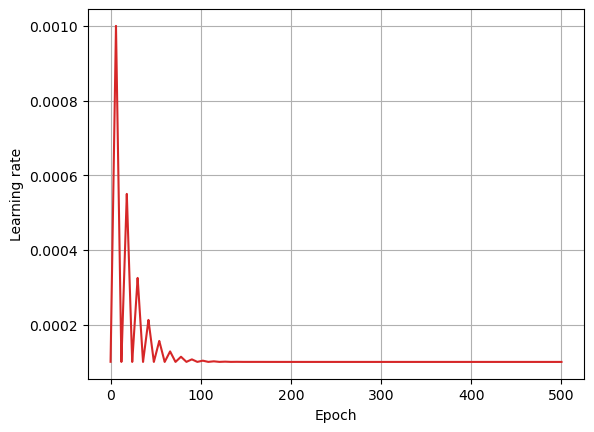

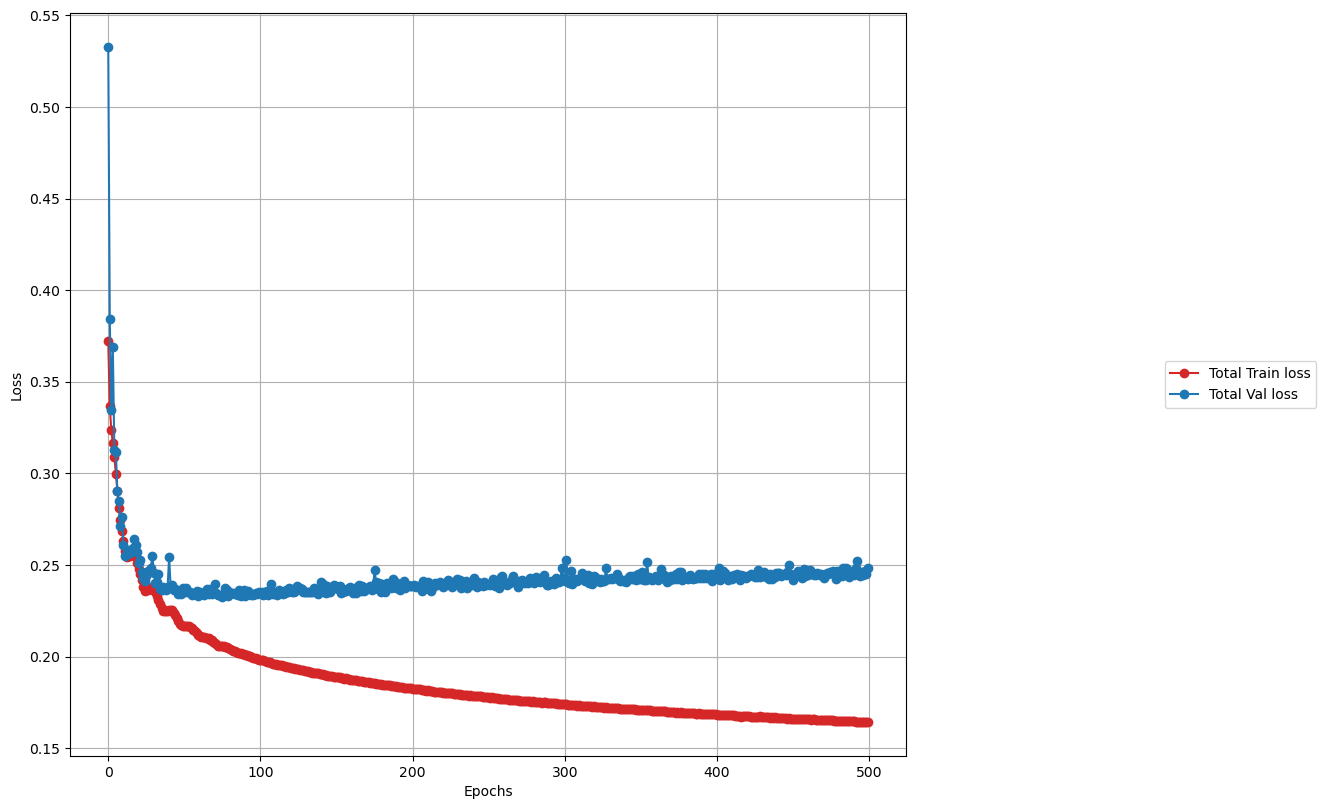

In [28]:
batches = np.linspace(0,len(metrics['lrs']),len(metrics['lrs'])+1)
epoch_list = batches/iterations_per_epoch

plt.plot(epoch_list[1:],metrics['lrs'], 'C3-')
plt.grid()
plt.ylabel("Learning rate")
plt.xlabel("Epoch")


losses_arr = np.array(metrics['losses'])
val_losses_arr = np.array(metrics['val_losses'])
losses_arr.shape
fig, ax = plt.subplots(1,sharex=True, figsize=(15, 8))
ax.plot(losses_arr[:,0], 'C3o-', label = "Total Train loss")
ax.plot(val_losses_arr[:,0], 'C0o-', label = "Total Val loss")
ax.set(ylabel='Loss')
ax.grid()
ax.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.tight_layout()
plt.xlabel("Epochs")
plt.show()

<Figure size 640x480 with 0 Axes>

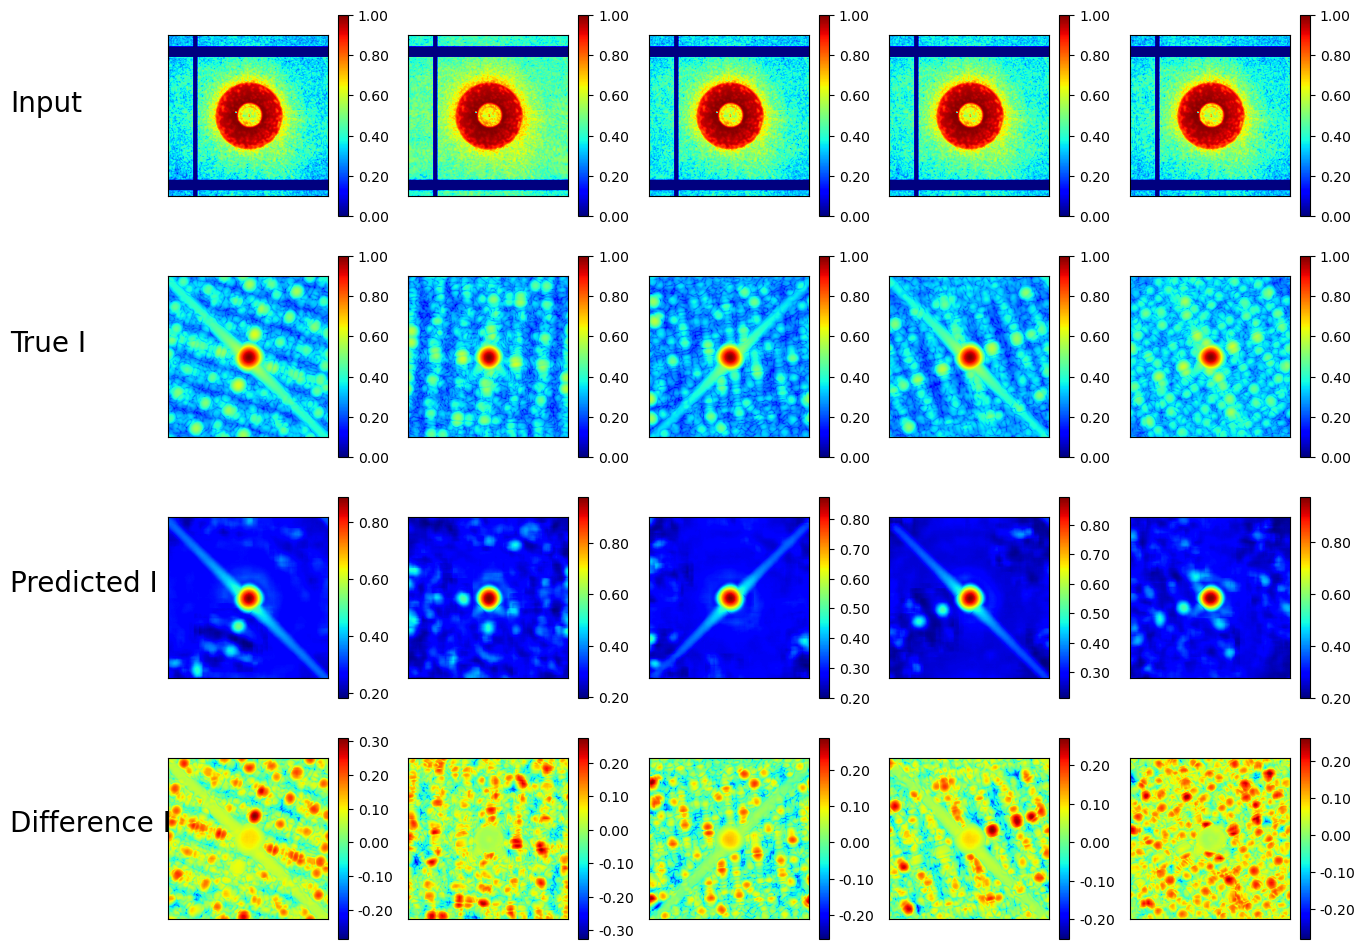

In [29]:
model.eval()
#model_new.eval() #imp when have dropout etc
results = []
for i, test in enumerate(testloader):
    tests = test[0].to(device)
    testsp = test[1].to(device)
    result = model(tests)
    for j in range(tests.shape[0]):
        results.append(result[j].detach().to("cpu").numpy())
        
results = np.array(results).squeeze()



h,w = H,W
ntest=results.shape[0]
plt.figure()
n = 5
f,ax=plt.subplots(4,n,figsize=(15, 12))
plt.gcf().text(0.02, 0.8, "Input", fontsize=20)
plt.gcf().text(0.02, 0.6, "True I", fontsize=20)
plt.gcf().text(0.02, 0.4, "Predicted I", fontsize=20)
plt.gcf().text(0.02, 0.2, "Difference I", fontsize=20)

for i in range(0,n):
    j=int(round(np.random.rand()*ntest))

    # display FT
    im=ax[0,i].imshow(X_test[j].reshape(h, w))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[0,i], format='%.2f')
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)

    # display original intens
    im=ax[1,i].imshow(Y_I_test[j].reshape(h, w))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[1,i], format='%.2f')
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)
    
    # display predicted intens
    im=ax[2,i].imshow(results[j].reshape(h, w))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[2,i], format='%.2f')
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)

    #Difference in amplitude
    im=ax[3,i].imshow(Y_I_test[j].reshape(h, w)-results[j].reshape(h, w))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[3,i], format='%.2f')
    ax[3,i].get_xaxis().set_visible(False)
    ax[3,i].get_yaxis().set_visible(False)
plt.show()

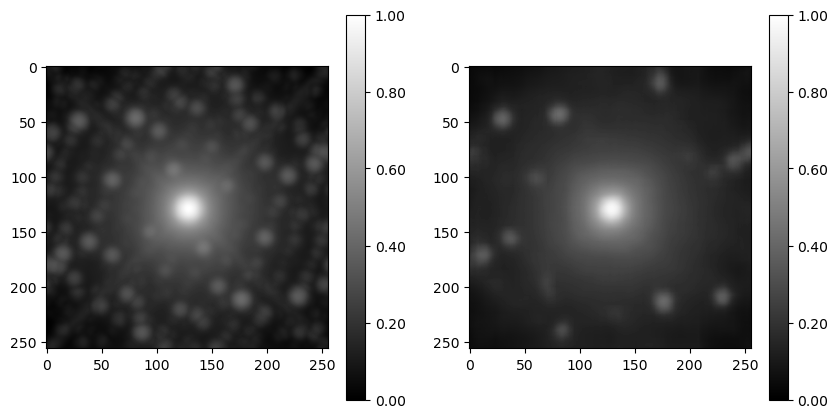

29.263245481200762


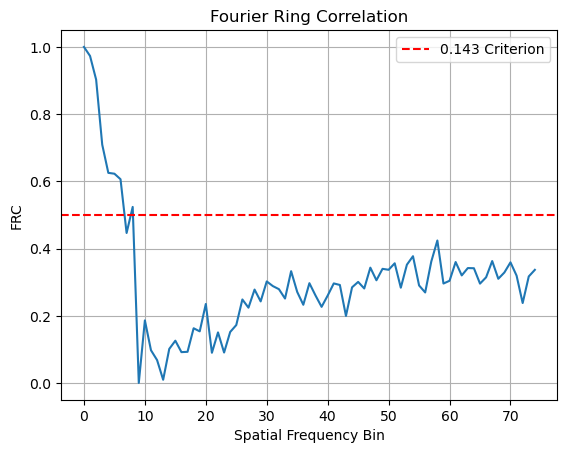

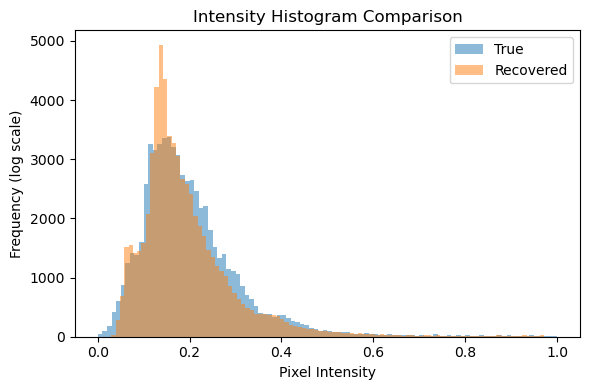

In [16]:
def compute_psnr(img_true, img_recon, max_val=1.0):
    """Compute PSNR between ground truth and reconstructed images."""
    mse = np.mean((img_true - img_recon) ** 2)
    if mse == 0:
        return float('inf')  # Perfect match
    psnr = 10 * np.log10((max_val ** 2) / mse)
    return psnr

def compute_frc(image1, image2, num_bins=50):
    """Compute the Fourier Ring Correlation between two images."""
    # Compute Fourier transforms
    F1 = fftshift(fft2(image1))
    F2 = fftshift(fft2(image2))

    fig,ax=plt.subplots(1,2,figsize=(10, 5))
    im1=ax[0].imshow(image1, cmap='gray',clim=(0,1))
    im2=ax[1].imshow(image2, cmap='gray',clim=(0,1))
    plt.colorbar(im1, ax=ax[0], format='%.2f')
    plt.colorbar(im2, ax=ax[1], format='%.2f')
    plt.show()
    # Prepare coordinates
    h, w = F1.shape
    y, x = np.indices((h, w))
    center = (h // 2, w // 2)
    r = np.sqrt((x - center[1]) ** 2 + (y - center[0]) ** 2)

    # Bin radial frequencies
    r = r.astype(np.int32)
    max_r = min(center)
    frc = np.zeros(num_bins)
    for i in range(num_bins):
        ring_mask = (r >= i * max_r / num_bins) & (r < (i + 1) * max_r / num_bins)
        F1_ring = F1[ring_mask]
        F2_ring = F2[ring_mask]
        num = np.sum(F1_ring * np.conj(F2_ring))
        denom = np.sqrt(np.sum(np.abs(F1_ring) ** 2) * np.sum(np.abs(F2_ring) ** 2))
        frc[i] = np.abs(num / denom) if denom != 0 else 0
    return frc

def plot_intensity_histograms(img1, img2, labels=('True', 'Recovered'), bins=100):
    plt.figure(figsize=(6,4))
    plt.hist(img1.ravel(), bins=bins, alpha=0.5, label=labels[0])
    plt.hist(img2.ravel(), bins=bins, alpha=0.5, label=labels[1])
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency (log scale)')
    plt.title('Intensity Histogram Comparison')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
j=int(round(np.random.rand()*ntest))
IMAGE1=Y_I_test[j].reshape(h, w)   
IMAGE2=results[j].reshape(h, w)
frc_curve = compute_frc(IMAGE1, IMAGE2,num_bins=75)
print(compute_psnr(IMAGE1, IMAGE2))
plt.plot(frc_curve)
plt.axhline(0.5, color='r', linestyle='--', label='0.143 Criterion')
plt.xlabel('Spatial Frequency Bin')
plt.ylabel('FRC')
plt.title('Fourier Ring Correlation')
plt.legend()
plt.grid(True)
plt.show()
plot_intensity_histograms(IMAGE1, IMAGE2)